# 5장 : 오차역전파법
앞 장에서는 신경망 학습에 대해서 설명하였다. 그때 신경망의 가중치 매개변수의 기울기 (정확히는 가중치 매개변수에 대한 손실 함수의 기울기)는 수치 미분을 사용해 구하였다. 수치 미분은 단순하고 구현하기도 쉽지만 계산 시간이 오래 걸린다는게 단점이다. 이번 장에서는 가중치 매개변수의 기울기를 효율적으로 계산하는 '$\small \textbf{오차역전파법}^{\text{backpropagation}}$'을 배워보도록 한다.      

오차역전파법을 제대로 이해하는 방법은 두 가지가 있을 것이다. 하나는 수식을 통한 것이고, 다른 하나는 계산 그래프를 통한 것이다. 전자 쪽이 일반적인 방법으로, 특히 기계학습을 다루는 책 대부분은 수식을 중심으로 이야기를 전개한다. 확실히 수식을 사용한 설명은 정확하고 간결하므로 올바른 방법이라 할 수 있다. 하지만 졸업 후 너무 오랜만에 수식을 중심으로 생각하다 보면 본질을 놓치거나, 수많은 수식에 당황하는 일이 벌어지기도 한다. 그래서 이번 장에서는 계산 그래프를 사용해서 '시각적'으로 이해해보도록 한다. 그런 다음 실제로 코드를 작성해보면 '과연!'이란 탄성과 함께 더 깊이 이해할 수 있을 것이다.        

오차역전파법을 계산 그래프로 설명한다는 생각은 $\small \text{안드레 카파시}^{\text{Andrej Kapathy}}$의 블로그, 또 그와 $\small \text{페이페이 리}^{\text{Fei-Fei Li}}$교수가 진행한 스탠퍼드 대학교의 딥러닝 수업 CS231n을 참고하였음을 밝힌다.

## 5.1 계산 그래프
$\small \textbf{계산 그래프}^{\text{computational graph}}$ 는 계산 과정을 그래프로 나타낸 것이다. 여기에서의 그래프는 우리가 잘 아는 그래프 자료구조로, 복수의 $\small \text{노드}^{\text{node}}$와 $\small \text{에지}^{\text{edge}}$로 표현된다.(노드 사이의 직선을 '에지'라고 한다) 이번 절에서는 계산 그래프에 친숙해지기 위한 간단한 문제를 풀어보고자 한다. 간단한 문제에서부터 한 단계씩 나아가면서 마지막에는 오차역전파법에 도달할 예정이다.

### 5.1.1 계산 그래프로 풀다
그럼 간단한 문제를 계산 그래프를 사용해서 풀어보자. 곧 보게 될 문제는 암산으로도 풀 정도로 간단하지만 지금의 목적은 계산 그래프에 익숙해지는 것이다. 계산 그래프는 뒤에 나올 복잡한 계산에서 진짜 위력을 발휘하므로, 지금 기회에 꼭 그 사용법을 익혀두길 권장한다.

$\textbf{문제 1: 현빈 군은 슈퍼에서 1개에 100원인 사과를 2개 샀습니다. 이때 지불 금액을 구하세요. 단, 소비세가 10\% 부과됩니다.}$

계산 그래프는 계산 과정을 노드와 화살표로 표현한다. 노드는 원$(\circ)$으로 표기하고 원 안에 연산 내용을 적는다. 또, 계산 결과를 화살표 위에 적어 각 노드의 계산 결과가 왼쪽에서 오른쪽으로 전해지게 한다. 문제 1을 계산 그래프로 풀면 [그림5-1]처럼 된다.

#### [그림5-1] 계산 그래프로 풀어본 문제1의 답

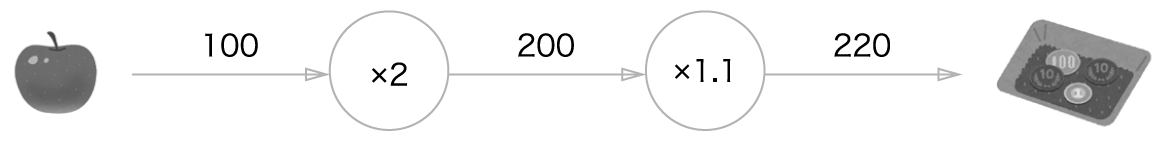

In [1]:
from PIL import Image
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-1.png")

[그림5-1]과 같이 처음에 사과의 100원이 '$\times 2$'노드로 흐르고, 200원이 되어 다음 노드로 전달된다. 이제 200원이 '$\times 1.1$'노드를 거쳐 220원이 된다. 따라서 이 계산 그래프에 따르면 최종 답은 220원이 된다.        

또한, [그림5-1]에서는 '$\times 2$'와 '$\times 1.1$'을 각각 하나의 연산으로 취급해 원 안에 표기했지만, 곱셈인 '$\times$'만을 연산으로 생각할 수도 있다. 이렇게 하면 [그림5-2]처럼 '2'와 '1.1'은 각각 '사과의 개수'와 '소비세' 변수가 되어 원 밖에 표기된다.

#### [그림5-2] 계산 그래프로 풀어본 문제 1의 답 : '사과의 개수'와 '소비세'를 변수로 취급해 원 밖에 표기

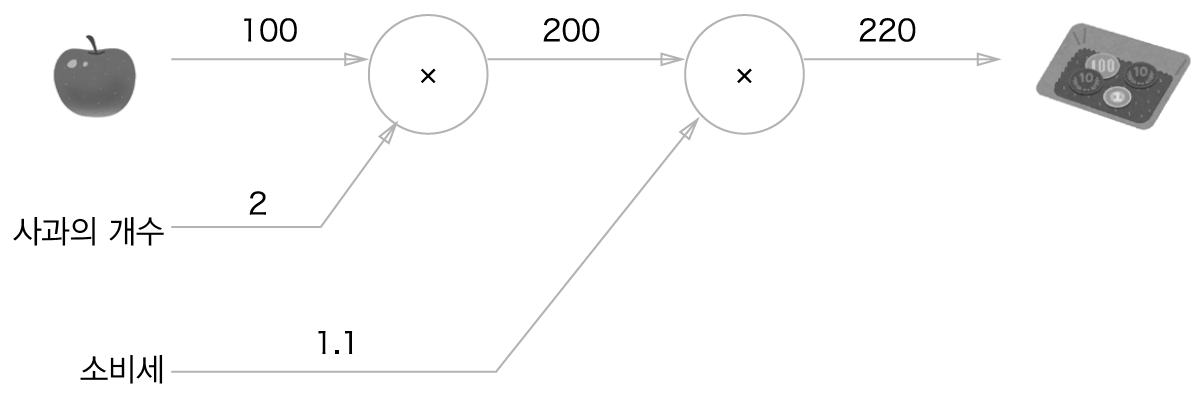

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-2.png")

$\textbf{문제 2: 현빈 군은 슈퍼에서 사과를 2개, 귤을 3개 샀습니다. 사과는 1개에 100원, 귤은 1개 150원입니다. 소비세가 10\% 일 때 지불 금액을 구하세요.}$

문제 2도 문제 1과 같이 계산 그래프로 풀도록 한다. 이때의  계산 그래프는 [그림5-3]처럼 된다.

#### [그림5-3] 계산 그래프로 풀어본 문제 2의 답

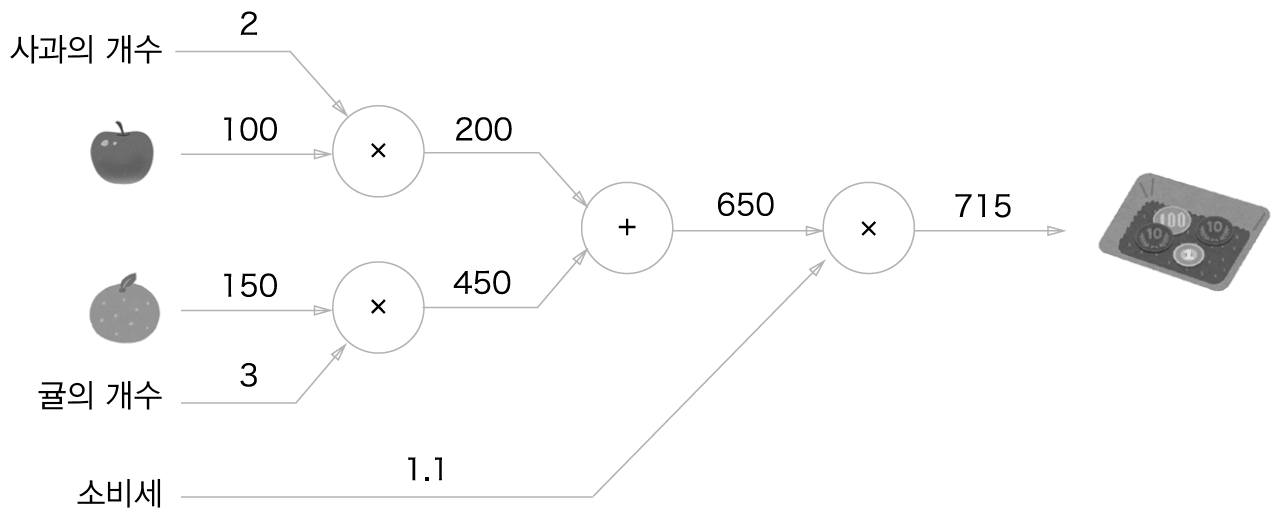

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-3.png")

이 문제에는 덧셈 노드인 '$+$'가 새로 등장하여 사과와 귤의 금액을 합산한다. 계산 그래프는 왼쪽에서 오른쪽으로 계산을 진행한다. 회로에 전류가 흐르듯 계산 결과가 왼쪽에서 오른쪽으로 전달된다고 생각하면 된다. 계산 결과가 오른쪽 끝에 도착하면 거기서 끝! 그래서 [그림5-3]에서의 답은 715원이다.

지금까지 살펴본 것처럼 계산 그래프를 이용한 문제 풀이는 다음 흐름으로 진행된다.
1. 계산 그래프를 구성한다.
2. 그래프에서 계산을 왼쪽에서 오른쪽으로 진행한다.

여기서 2번째 '계산을 왼쪽에서 오른쪽으로 진행'하는 단계를 $\small \textbf{순전파}^{\text{forward propagation}}$라고 한다. 순전파는 계산 그래프의 출발점부터 종착점으로의 전파이다. 순전파라는 이름이 있다면 반대 방향(그림에서 말하면 오른쪽에서 왼쪽)의 전파도 가능할까? 그렇다! 그것을 $\small \textbf{역전파}^{\text{backward propagation}}$라고 한다. 역전파는 이후에 미분을 계산할 때 중요한 역할을 한다.

### 5.1.2 국소적 계산
계산 그래프의 특징은 '국소적 계산'을 전파함으로써 최종 결과를 얻는다는 점에 있다. 국소적이란 '자신과 직접 관계된 작은 범위'라는 뜻이다. 국소적 계산은 결국 전체에서 어떤 일이 벌어지든 상관없이 자신과 관계된 정보만으로 결과를 출력할 수 있다는 것이다.        

국소적 계산을 구체적인 예를 들어 설명해보고자 한다. 가령 슈퍼마켓에서 사과 2개를 포함한 여러 식품을 구입하는 경우를 생각해보자. 이를 [그림5-4]와 같은 계산 그래프로 나타낼 수 있을 것이다.

#### [그림5-4] 사과 2개를 포함해 여러 식품을 구입하는 예

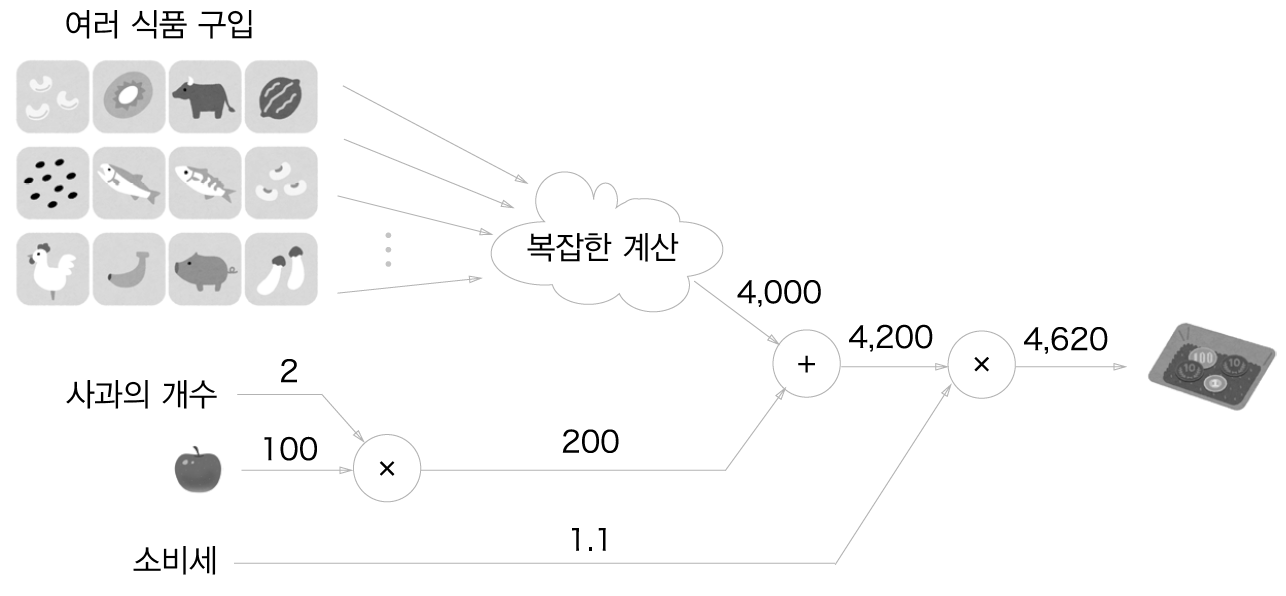

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-4.png")

[그림5-4]에서는 여러 식품을 구입하여 (복잡한 계산을 거쳐) 총금액이 4,000원이 되었다. 여기에서 핵심은 각 노드에서의 계산은 국소적 계산이라는 점이다. 가령 사과와 그 외의 물품 값을 더하는 계산$(4,000 + 200 \rightarrow 4,200)$은 4,000이라는 숫자가 어떻게 계산되었느냐와는 상관없이, 단지 두 숫자를 더하면 된다는 뜻이다. 각 노드는 자신과 관련한 계산(이 예에서는 입력된 두 숫자의 덧셈) 외에는 아무것도 신경 쓸게 없다.      

이처럼 계산 그래프는 국소적 계산에 집중한다. 전체 계산이 제아무리 복잡하더라도 각 단계에서 하는 일은 해당 노드의 '국소적 계산'이다. 국소적인 계산은 단순하지만, 그 결과를 전달함으로써 전체를 구성하는 복잡한 계산을 해낼 수 있다.

$\textbf{NOTE}$     
> 비유하자면 복잡한 자동차 조립은 일반적으로 '조립 라인 작업'에 의한 분업으로 행해진다. 각 담당자(담당 기계)는 단순화된 일만 수행하며 그 일의 결과가 다음 담당자로 전달되어 최종적으로 차를 완성한다. 계산 그래프도 복잡한 계산을 '단순하고 국소적 계산'으로 분할하고 조립 라인 작업을 수행하며 계산 결과를 다음 노드로 전달한다. 복잡한 계산도 분해하면 단순한 계산으로 구성된다는 점은 자동차 조립과 마찬가지인 것이다.

### 5.1.3 왜 계산 그래프로 푸는가?
지금까지 계산 그래프를 써서 두 문제를 풀어보았다. 자, 계산 그래프의 이점은 무엇인가? 이점 하나는 방금 설명한 '국소적 계산'이다. 전체가 아무리 복잡하더라도 각 노드에서는 단순한 계산에 집중하여 문제를 단순화할 수 있다. 또 다른 이점으로, 계산 그래프는 중간 계산 결과를 모두 보관할 수 있다는 점이다. 예를 들어 사과 2개까지 계산했을 때의 금액은 200원, 소비세를 더하기 전의 금액은 650원인 식이다. 그러나 이 정도만으로는 계산 그래프를 사용하는 이유가 충분히 와 닿지 않을지도 모른다. 자, 이것이 전부가 아니다. 실제 계산 그래프를 사용하는 가장 큰 이유는 역전파를 통해 '미분'을 효율적으로 계산할 수 있다는 점에 있다.      

계산 그래프의 역전파를 설명하기 위해 문제 1을 다시 꺼내보도록 한다. 문제 1은 사과를 2개 사서 소비세를 포함한 최종 금액을 구하는 것이었다. 여기서 가령 사과 가격이 오르면 최종 금액에 어떤 영향을 끼치는지를 알고 싶다고 하자. 이는 '사과 가격에 대한 지불 금액의 미분'을 구하는 문제에 해당한다. 기호로 나타낸다면 사과 값을 $x$, 지불 금액을 $L$이라 했을 때 $\small \tfrac{\partial L}{\partial x}$을 구하는 것이다. 이 미분 값은 사과 값이 '아주 조금'올랐을 때 지불 금액이 얼마나 증가하느냐를 표시한 것이다.       

앞에서 말했듯이 '사과 가격에 대한 지불 금액의 미분'같은 값은 계산 그래프에서 역전파를 하면 구할 수 있다. 먼저 결과만을 나타내면 [그림5-5]처럼 계산 그래프 상의 역전파에 의해서 미분을 구할 수 있다.(역전파가 어떻게 이뤄지느냐는 곧 설명할 것이다)

#### [그림5-5] 역전파에 의한 미분 값의 전달

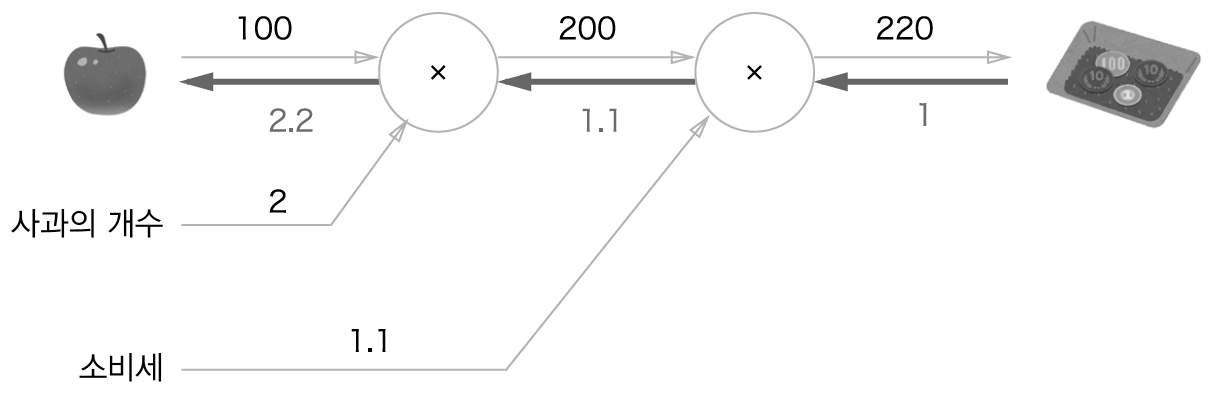

In [6]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-5.png")

[그림5-5]와 같이 역전파는 순전파와는 반대 방향의 화살표(굵은 선)으로 그린다. 이 전파는 '국소적 미분'을 전달하고 그 미분 값은 화살표의 아래에 적는다. 이 예에서 역전파는 오른쪽에서 왼쪽으로 '$1 \rightarrow 1.1 \rightarrow 2.2$'순으로 미분 값을 전달한다. 이 결과로부터 '사과 가격에 대한 지불 금액의 미분'값은 2.2라 할 수 있다. 사과가 1원 오르면 최종 금액은 2.2원 오른다는 뜻이다.(정확히는 사과 값이 아주 조금 오르면 최종 금액은 그 아주 작은 값의 2.2배만큼 오른다는 뜻이다)       

여기에서는 사과 가격에 대한 미분만 구했지만, '소비세에 대한 지불 금액의 미분'이나 '사과 개수에 대한 지불 금액의 미분'도 같은 순서로 구할 수 있다. 그리고 그때는 중간까지 구한 미분 결과를 공유할 수 있어서 다수의 미분을 효율적으로 계산할 수 있다. 이처럼 계산 그래프의 이점은 순전파와 역전파를 활용해서 각 변수의 미분을 효율적으로 구할 수 있다는 것이다.

## 5.2 연쇄법칙
그동안 해온 계산 그래프의 순전파는 계산 결과를 왼쪽에서 오른쪽으로 전달했다. 이 순서는 평소 하는 방식이니 자연스럽게 느껴졌을 것이다. 한편 역전파는 '국소적인 미분'을 순방향과는 반대인 오른쪽에서 왼쪽으로 전달한다.(처음 보면 당황할 수도 있다) 또한, 이 '국소적 미분'을 전달하는 원리는 $\small \textbf{연쇄법칙}^{\text{chain rule}}$에 따른 것이다. 이번 절에서는 연쇄법칙을 설명하고 그것이 계산 그래프 상의 역전파와 같다는 사실을 밝히고자 한다.

### 5.2.1 계산 그래프의 역전파
서둘러 계산 그래프를 사용한 역전파의 예를 하나 살펴보도록 하자. $y=f(x)$라는 계산의 역전파를 [그림5-6]과 같이 그려보았다.

#### [그림5-6] 계산 그래프의 역전파 : 순방향과는 반대 방향으로 국소적 미분을 곱한다.

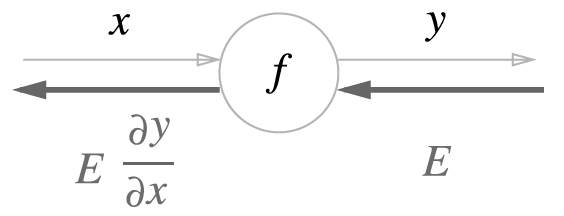

In [1]:
from PIL import Image
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-6.png")

그림 [5-6]과 같이 역전파의 계산 절차는 신호 $E$에 노드의 국소적 미분 $(\small \tfrac{\partial y}{\partial x})$을 곱한 후 다음 노드로 전달하는 것이다. 여기에서 말하는 국소적 미분은 순전파 때의 $ y=f(x) $ 계산의 미분을 구한다는 것이며, 이는 $x$ 에 대한 $y$의 미분 $(\small \tfrac{\partial y}{\partial x})$을 구한다는 뜻이다. 가령 $y=f(x)=x^{2}$이라면 $\small \tfrac{\partial y}{\partial x} = 2x$가 된다. 그리고 이 국소적인 미분을 상류에서 전달된 값(이 예에서는 $E$)에 곱해 앞쪽 노드로 전달하는 것이다.     

이것이 역전파의 계산순서인데, 이러한 방식을 따르면 목표로 하는 미분 값을 효율적으로 구할 수 있다는 것이 이 전파의 핵심이다. 왜 그런 일이 가능한가는 연쇄법칙의 원리로 설명할 수 있다. 그럼 이쯤에서 연쇄법칙에 대해 설명하고자 한다.        

### 5.2.2 연쇄법칙이란?
연쇄법칙을 설명하려면 우선 합성 함수 이야기부터 시작해야 한다. $\small \textbf{합성 함수}$란 여러 함수로 구성된 함수이다. 예를 들어 $z= (x+y)^{2}$이라는 식은 식 (5.1)처럼 두 개의 식으로 구성된다.

\begin{equation*}
    z = t^{2}
\end{equation*}

\begin{equation*}
    t = x + y
\end{equation*} \tag{5.1}

연쇄법칙은 합성 함수의 미분에 대한 성질이며, 다음과 같이 정의된다.

$\textbf{합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.}$

이것이 연쇄법칙의 원리이다. 언뜻 어렵게 보일지도 모르지만 간단한 성질이다. 식 (5.1)을 예로 설명하면, $\small \tfrac{\partial z}{\partial x}$ ($x$에 대한 $z$의 미분)은 $\small \tfrac{\partial z}{\partial t}$ ($t$에 대한 $z$의 미분)와 $\small \tfrac{\partial t}{\partial x}$ ($x$에 대한 $t$의 미분)의 곱으로 나타낼 수 있다는 것이다. 수식으로는 식 (5.2)처럼 쓸 수 있다.      

\begin{equation*}
    \frac{\partial z}{\partial x} = \frac{\partial z}{\partial t} \frac{\partial t}{\partial x}
\end{equation*} \tag{5.2}

그럼 연쇄법칙을 써서 식 (5.2)의 미분 $\small \tfrac{\partial z}{\partial x}$ 를 구해보자. 가장 먼저 식 (5.1)의 국소적 미분(편미분)을 구하자.

\begin{equation*}
    \frac{\partial z}{\partial t} = 2t
\end{equation*}

\begin{equation*}
    \frac{\partial t}{\partial x} = 1
\end{equation*} \tag{5.3}



식 (5.3)과 같이 $\small \tfrac{\partial z}{\partial t}$는 $2t$이고, $\small \tfrac{\partial t}{\partial x}$는 1이다. 이는 미분 공식에서 해석적으로 구한 결과이다. 그리고 최종적으로 구하고 싶은 $\small \tfrac{\partial z}{\partial x}$는 식 (5.3)에서 구한 두 미분을 곱해서 계산해서 구할 수 있다.

\begin{equation*}
    \frac{\partial z}{\partial x} = \frac{\partial z}{\partial t} \frac{\partial t}{\partial x} = 2t \cdot 1 = 2 (x+y)
\end{equation*}

### 5.2.3 연쇄법칙과 계산 그래프
그럼 식 (5.4)의 연쇄법칙 계산을 계산 그래프로 나타내보자. 2제곱 계산을 '**2' 노드로 나타내면 [그림5-7]처럼 그릴 수 있다.

#### [그림5-7] 식 (5.4)의 계산 그래프 : 순전파와는 반대 방향으로 국소적 미분을 곱하여 전달한다.

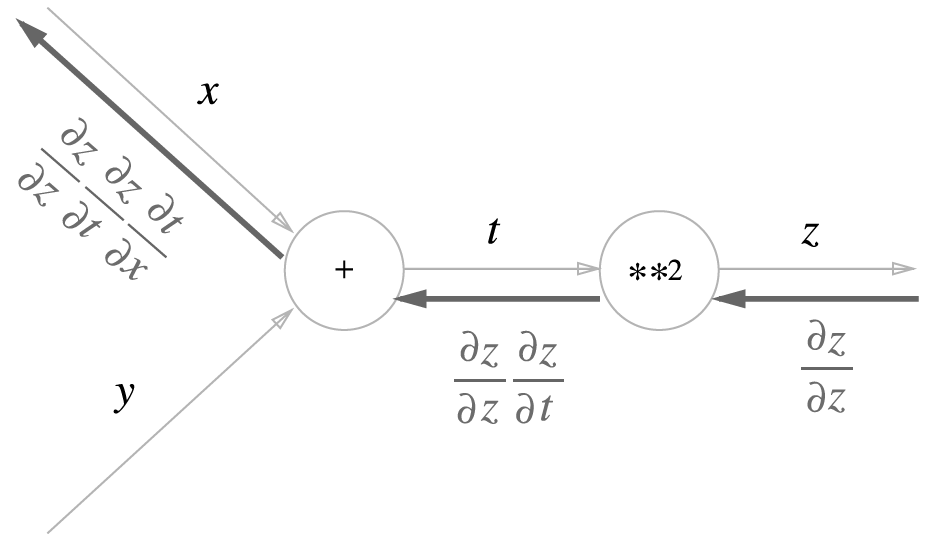

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-7.png")

[그림 5-7]과 같이 계산 그래프의 역전파는 오른쪽에서 왼쪽으로 신호를 전파한다. 역전파의 계산 절차에서는 노드로 들어온 입력 신호에 그  노드의 국소적 미분 (편미분)을 곱한 후 다음 노드로 전달한다. 예를 들어 '**2'노드에서의 역전파를 보자. 입력은 $\small \tfrac{\partial z}{\partial z}$이며, 이에 국소적 미분인 $\small \tfrac{\partial z}{\partial t}$(순전파 시에는 입력이 $t$이고 출력이 $z$이므로 이 노드에서 (국소적)미분은 $\small \tfrac{\partial z}{\partial z}$이다)를 곱하고 다음 노드로 넘긴다. 한 가지, [그림5-7]에서 역전파의 첫 신호인 $\small \tfrac{\partial z}{\partial z}$의 값은 결국 1이라서 앞의 수식에서는 언급하지 않았다.

그런데 [그림5-7]에서 주목할 것은 맨 왼쪽 역전파인데, 이 계산은 연쇄법칙에 따르면 $\small \tfrac{\partial z}{\partial z} \small \tfrac{\partial z}{\partial t} \small \tfrac{\partial t}{\partial x} = \small \tfrac{\partial z}{\partial t} \small \tfrac{\partial t}{\partial x} = \small \tfrac{\partial z}{\partial x}$가 성립되어 '$x$에 대한 $z$의 미분'이 된다. 즉, 역전파가 하는 일은 연쇄법칙의 원리와 같다는 것이다.       

[그림5-7]에 식 (5.3)의 결과를 대입하면 [그림5-8]이 되며, $\small \tfrac{\partial z}{\partial x}$는 $2(x+y)$임을 구할 수 있다.

#### [그림5-8] 계산 그래프의 역전파 결과에 따르면 $\small \tfrac{\partial z}{\partial x}$는 $2(x+y)$가 된다.

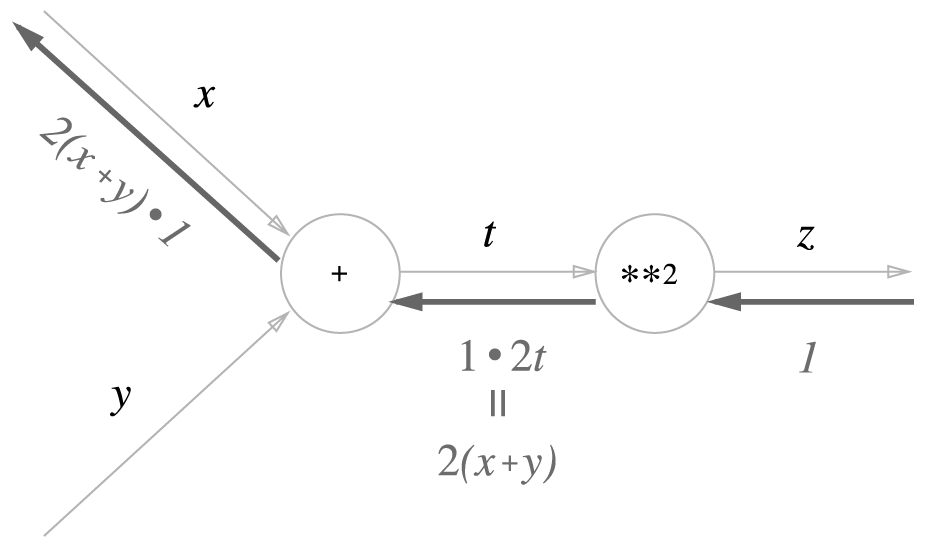

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-8.png")

## 5.3 역전파
앞 절에서는 계산 그래프의 역전파가 연쇄법칙에 따라 진행되는 모습을 설명하였다. 이번 절에서는 $'+'$와 $'\times'$등의 연산을 예로 들어 역전파의 구조에 대해 설명하고자 한다.

### 5.3.1 덧셈 노드의 역전파
먼저 덧셈 노드의 역전파이다. 여기에서는 $z=x+y$라는 식을 대상으로 그 역전파를 살펴보고자 한다. 우선 $z=x+y$의 미분은 다음과 같이 해석적으로 계산할 수 있다.

\begin{equation*}
    \frac{\partial z}{\partial x} = 1
\end{equation*}

\begin{equation*}
    \frac{\partial z}{\partial y} = 1
\end{equation*} \tag{5.5}

식 (5.5)에서와 같이 $\small \tfrac{\partial z}{\partial x}$와 $\small \tfrac{\partial z}{\partial y}$는 모두 1이 된다. 이를 계산 그래프로는 [그림5-9]와 같이 그릴 수 있다.

#### [그림5-9] 덧셈 노드의 역전파 : 왼쪽이 순전파, 오른쪽이 역전파다. 덧셈 노드의 역전파는 입력 값을 그대로 흘려보낸다.

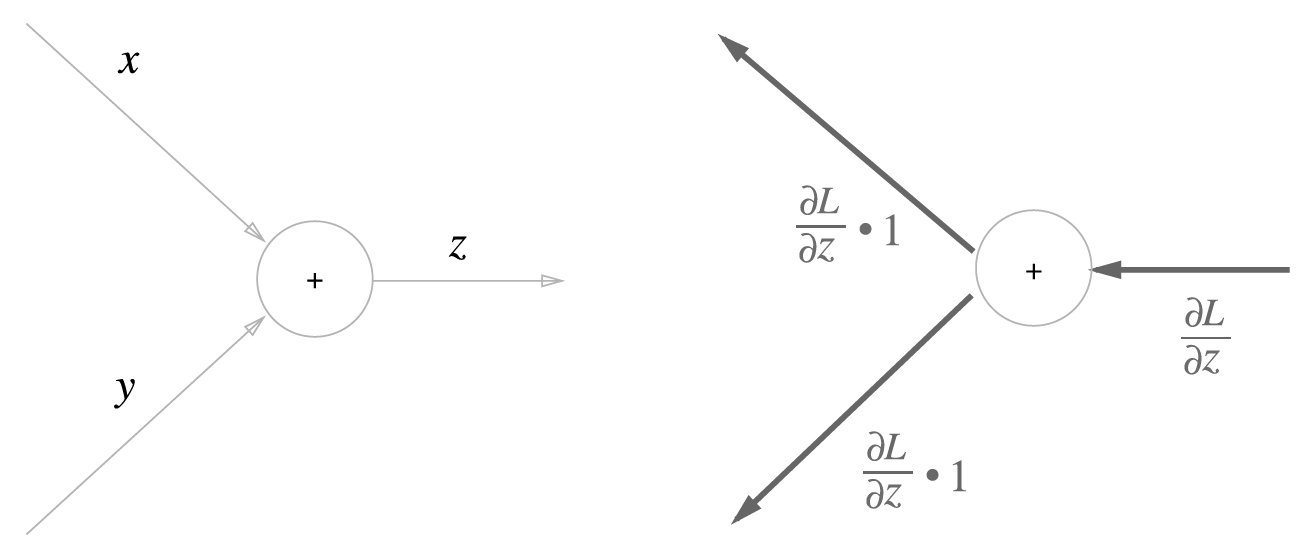

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-9.png")

[그림5-9]와 같이 역전파 때는 상류에서 전해진 미분(이 예에서는 $\small \tfrac{\partial L}{\partial z}$) 에 1을 곱하여 하류로 흘려보낸다. 즉, 덧셈 노드의 역전파는 1을 곱하기만 할 뿐이므로 입력된 값을 그대로 다음 노드로 보내게 된다.       

이 예에서는 상류에서 전해진 미분 값을 $\small \tfrac{\partial L}{\partial z}$이라 했는데, 이는 [그림5-10]과 같이 최종적으로 $L$이라는 값을 출력하는 큰 계산 그래프를 가정하기 때문이다. $z=x+y$계산은 그 큰 계산 그래프의 중간 어딘가에 존재하고, 상류로부터 $\small \tfrac{\partial L}{\partial z}$값이 전해진 것이다. 그리고 다시 하류로는 $\small \tfrac{\partial L}{\partial x}$와 $\small \tfrac{\partial L}{\partial y}$값을 전달하는 것이다.

#### [그림5-10]
최종 출력으로 가는 계산의 중간에 덧셈 노드가 존재한다. 역전파에서는 국소적 미분이 가장 오른쪽의 출력에서 시작하여 노드를 타고 역방향(왼쪽)으로 전파된다.

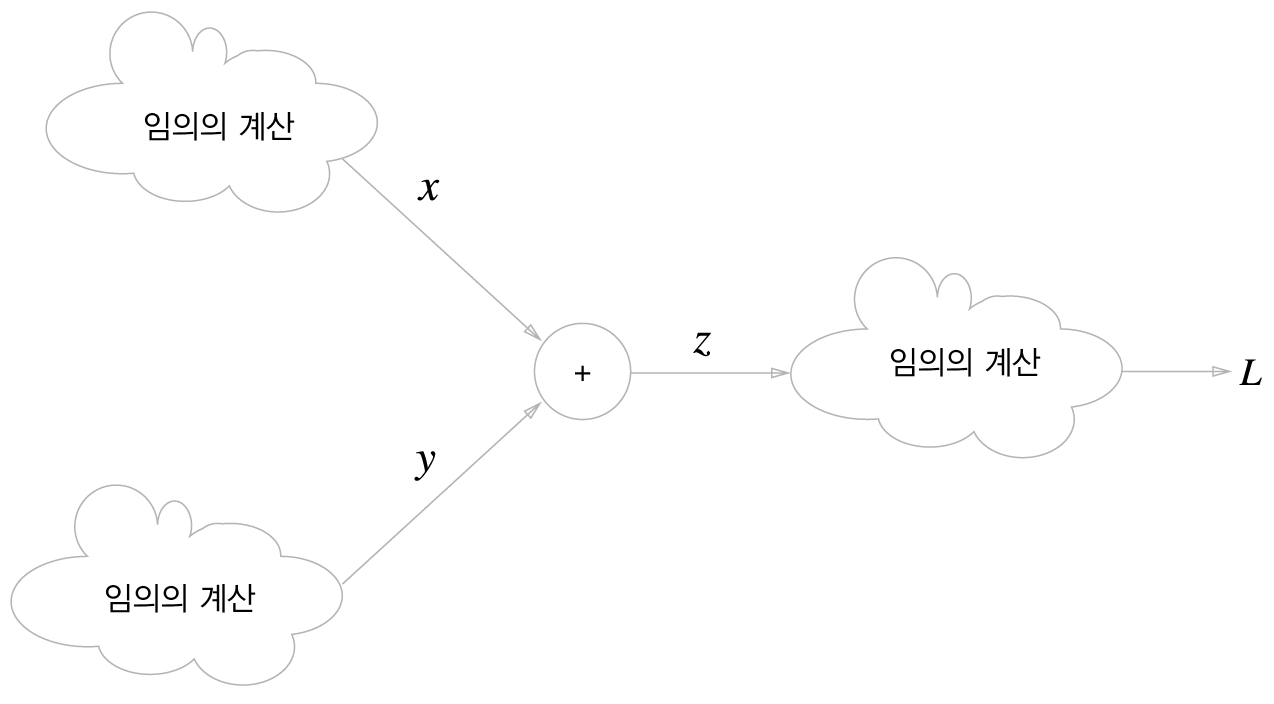

In [6]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-10.png")

이제 구체적인 예를 하나 살펴보자. 가령 $'10+5=15'$라는 계산이 있고, 상류에서 $1.3$이라는 값이 흘러오는 상황이다. 이를 계산 그래프로 그리면 [그림5-11]처럼 그려지게 된다.

#### [그림5-11] 덧셈 노드 역전파의 구체적인 예

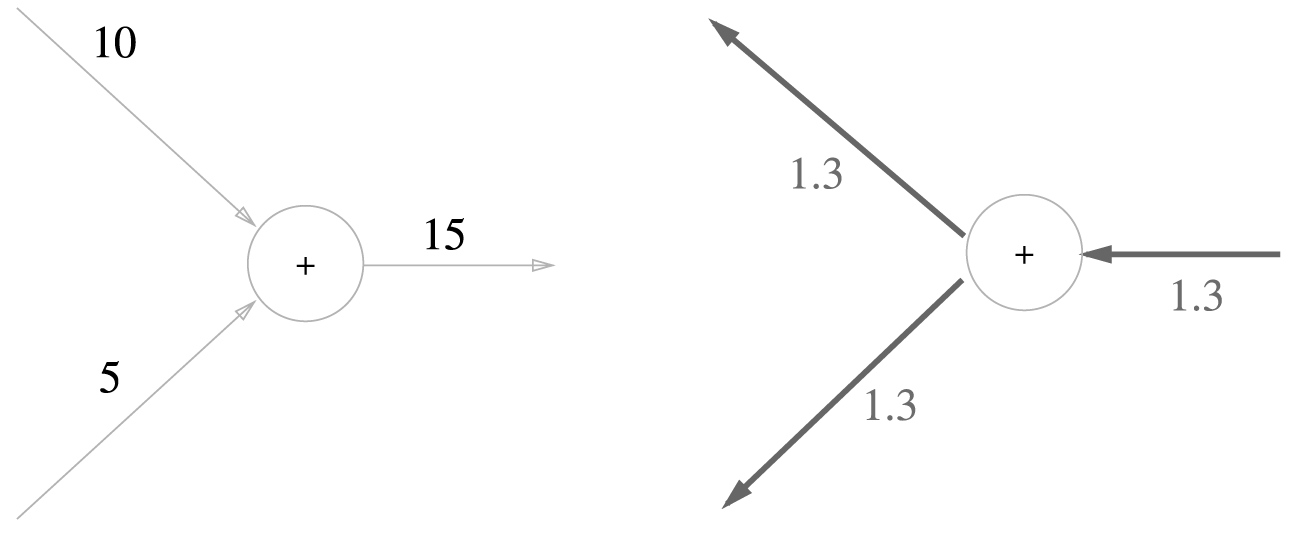

In [7]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-11.png")

덧셈 노드 역전파는 입력 신호를 다음 노드로 출력할 뿐이므로 [그림5-11]처럼 1.3을 그대로 다음 노드로 전달한다.

### 5.3.2 곱셈 노드의 역전파
이어서 곱셈 노드의 역전파에 대해 알아보도록 하자. $z=xy$라는 식을 생각해보자. 이 식의 미분은 다음과 같다.
\begin{equation*}
    \frac{\partial z}{\partial x} = y
\end{equation*}

\begin{equation*}
    \frac{\partial z}{\partial y} = x
\end{equation*} \tag{5.6}

식 (5.6)에서 계산 그래프는 다음과 같이 그릴 수 있다.

#### [그림5-12] 곱셈 노드의 역전파 : 왼쪽이 순전파, 오른쪽이 역전파이다.

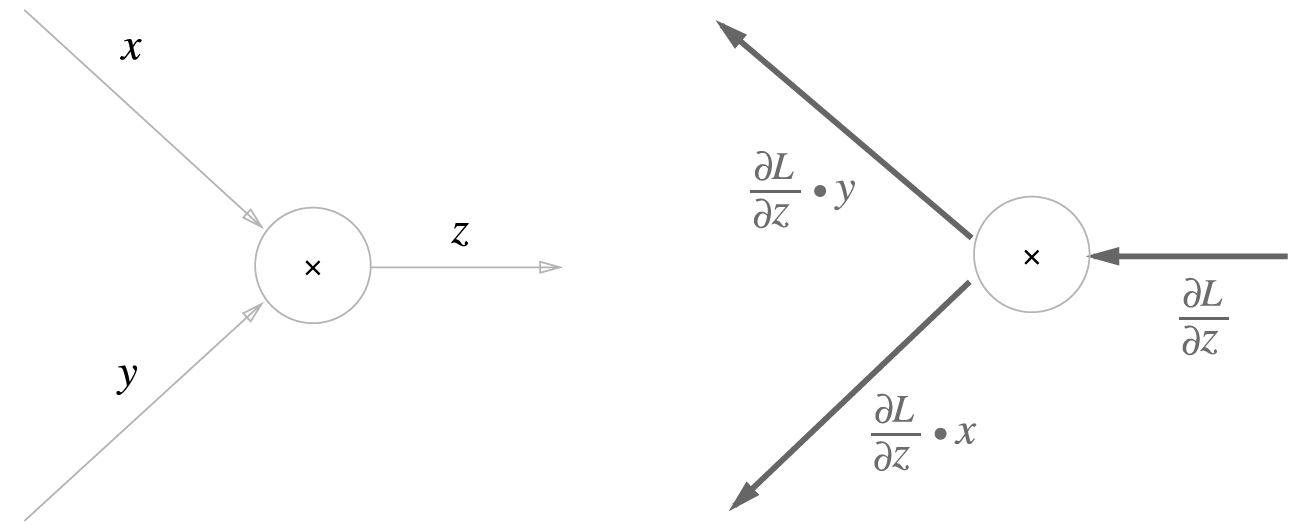

In [8]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-12.png")

곱셈 노드 역전파는 상류의 값에 순전파 때의 입력 신호들을 '서로 바꾼 값'을 곱해서 하류로 보낸다. 서로 바꾼 값이란 [그림5-12]처럼 순전파 때 $x$였다면 역전파에서는 $y$, 순전파 때 $y$였다면 역전파에서는 $x$로 바꾼다는 의미이다.     

그럼 구체적인 예를 하나 보자. 가령 $'10 \times 5 = 50'$이라는 계산이 있고, 역전파 때 상류에서 $1.3$값이 흘러나온다고 하자. 이를 계산 그래프로 그리면 [그림5-13]처럼 된다.

#### [그림5-13] 곱셈 노드 역전파의 구체적인 예

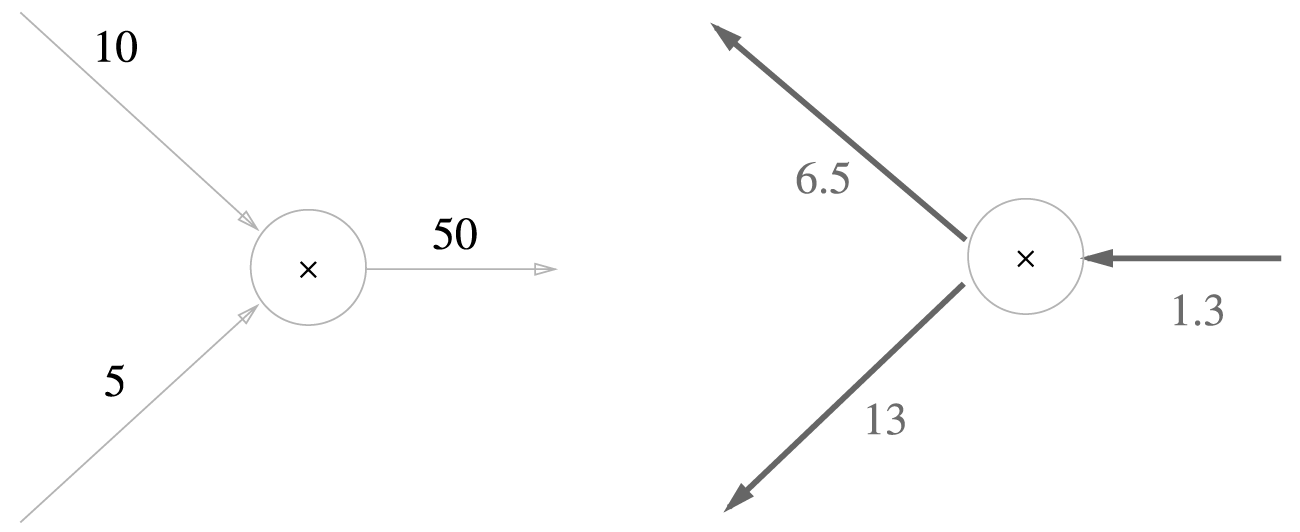

In [9]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-13.png")

곱셈의 역전파에서는 입력 신호를 바꾼 값을 곱하여 하나는 $1.3 \times 5 = 6.5,$ 다른 하나는 $1.3 \times 10 = 13$이 된다. 덧셈의 역전파에서는 상류의 값을 그대로 흘려보내서 순방향 입력 신호의 값은 필요하지 않았으나, 곱셈의 역전파는 순방향 입력 신호의 값이 필요하다. 그래서 곱셈 노드를 구현할 때는 순전파의 입력 신호를 변수에 저장해둔다.

### 5.3.3 사과 쇼핑의 예
이번 장을 시작할 때 본 사과 쇼핑 예를 다시 살펴보도록 한다. 이 문제에서는 사과의 가격, 사과의 개수, 소비세라는 세 변수 각각이 최종 금액에 어떻게 영향을 주느냐를 풀고자 한다. 이는 '사과 가격에 대한 지불 금액의 미분', '사과 개수에 대한 지불 금액의 미분', '소비세에 대한 지불 금액의 미분'을 구하는 것에 해당한다. 이를 계산 그래프의 역전파를 사용해서 풀면 [그림5-14]처럼 된다.

#### [그림5-14] 사과 쇼핑의 역전파 예

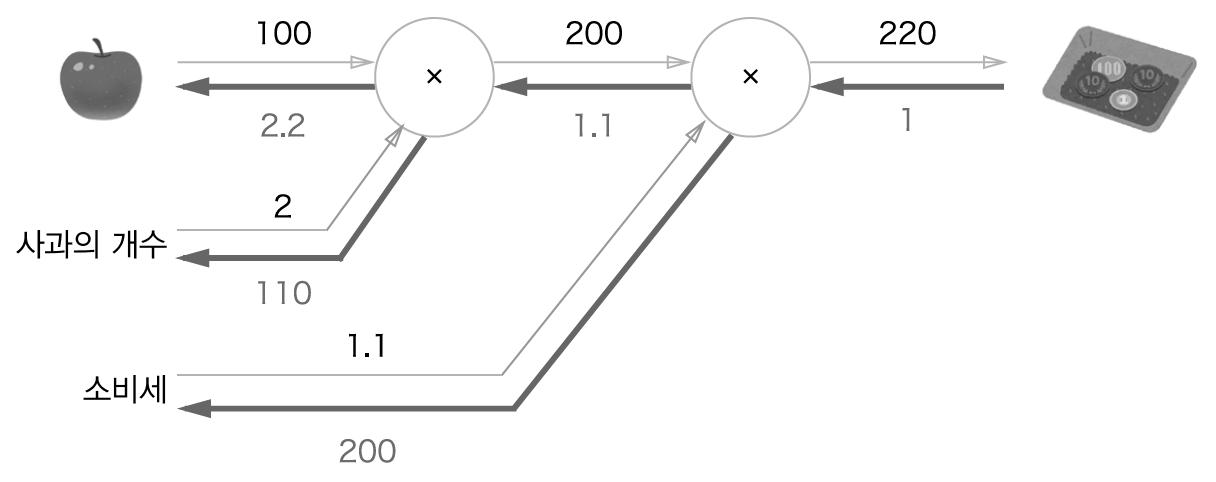

In [10]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-14.png")

지금까지 설명한 바와 같이 곱셈 노드의 역전파에서는 입력 신호를 서로 바꿔서 하류로 흘린다. [그림5-14]의 결과를 보면 사과 가격의 미분은 2.2, 사과 개수의 미분은 110, 소비세의 미분은 200이다. 이는 소비세와 사과 가격이 같은 양만큼 오르면 최종 금액에는 소비세가 200의 크기로, 사과 가격이 2.2 크기로 영향을 준다고 해석할 수 있다. 단, 이 예에서 소비세와 사과 가격은 단위가 다르니 주의해야 한다.(소비세 1은 100%, 사과 가격 1은 1원)      

정리할 겸, 마지막으로 '사과와 귤 쇼핑'의 역전파를 풀어보자. [그림5-15]의 빈 상자에 적당한 숫자를 넣어 각 변수의 미분을 구해보자.

#### [그림5-15] 사과와 귤 쇼핑의 역전파 예 : 빈 상자 안에 적절한 숫자를 넣어 역전파를 완성하시오.

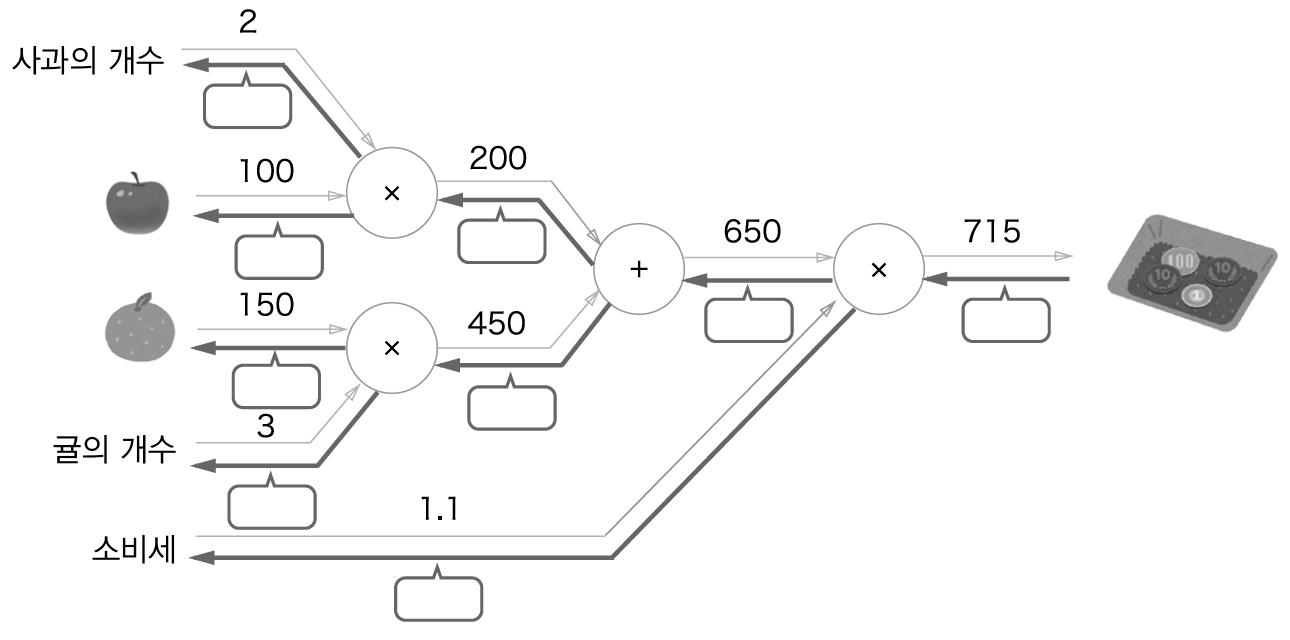

In [11]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-15.png")

## 5.4 단순한 계층 구현하기
이번 절에서는 지금까지 보아온 '사과 쇼핑'예를 파이썬으로 구현한다. 여기에서는 계산 그래프의 곱셈 노드를 'MulLayer', 덧셈 노드를 'AddLayer'라는 이름으로 구현하게 된다.

$\textbf{NOTE}$     
> 다음 절에서는 신경망을 구성하는 '계층' 각각을 하나의 클래스로 구현한다. 역에서 말하는 '계층'이란 신경망의 기능 단위이다. 예를 들어 시그모이드 함수를 위한 `Sigmoid`, 행렬 곱을 위한 `Affine`등의 기능을 계층 단위로 구현한다. 그래서 이번 절에서도 곱셈 노드와 덧셈 노드를 '계층'단위로 구현한다.

### 5.4.1 곱셈 계층
모든 계층은 `forward()`와 `backward()`라는 공통의 메서드(인터페이스)를 갖도록 구현할 것이다. `forward()`는 순전파, `backward()`는 역전파를 처리한다.        

그럼 먼저 곱셈 계층을 구현해보자. 곱셈 계층은 `MulLayer`라는 이름의 클래스로 다음과 같이 구현할 수 있다.

In [12]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

`__init__()`에서는 인스턴스 변수인 `x`와 `y`를 초기화한다. 이 두 변수는 순전파 시의 입력 값을 유지하기 위해서 사용한다. `forward()`에서는 `x`와 `y`를 인수로 받고 두 값을 곱해서 반환한다. 반면 `backward()`에서는 상류에서 넘어온 미분(dout)에 순전파 때의 값을 '서로 바꿔'곱한 후 하류로 흘려보낸다.      

이상이 `MulLayer`의 구현이다. 이 `MulLayer`를 사용해서 앞에서 본 '사과 쇼핑'을 구현해보자. 앞 절에서는 계산 그래프의 순전파와 역전파를 써서 [그림5-16]과 같이 계산할 수 있었다.

#### [그림5-16] 사과 2개 구입

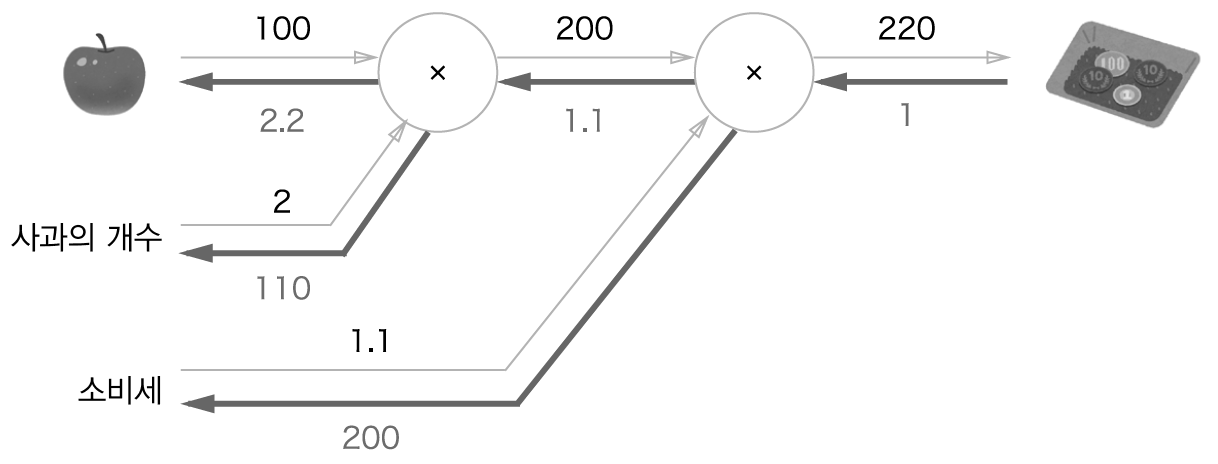

In [13]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-16.png")

`MulLayer`를 사용하여 [그림5-16]의 순전파를 다음과 같이 구현할 수 있다.

In [5]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from layer_naive import MulLayer

apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)  # 220


220.00000000000003


또한, 각 변수에 대한 미분은 `backward()`에서 구할 수 있다.

In [6]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from layer_naive import MulLayer

# 역전파
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)  # 2.2 110 200

2.2 110.00000000000001 200


`backward()`호출 순서는 `forward()`때와는 반대이다. 또, `backward()`가 받는 인수는 '순전파의 출력에 대한 미분'임에 주의하자. 가령 `mul_apple_layer`라는 곱셈 계층은 순전파 때는 `apple_price`를 출력하지만, 역전파 때는 `apple_price`의 미분 값인 `dapple_price`를 인수로 받는다. 마지막으로, 이 코드를 실행한 결과는 [그림5-16]의 결과와 일치한다.

### 5.4.2 덧셈 계층
이어서 덧셈 노드인 덧셈 계층을 구현하고자 한다. 덧셈 계층은 다음과 같이 구현할 수 있다.

In [13]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

덧셈 계층에서는 초기화가 필요 없으니 `__init__()`에서는 아무 일도 하지 않는다(`pass`는 '아무것도 하지 말라'라는 명령이다). 덧셈 계층의 `forward()`에서는 입력받은 두 인수 `x`,`y`를 더해서 반환한다. `backward()`에서는 상류에서 내려온 미분(`dout`)을 그대로 하류로 흘려보낼뿐이다.        

이상의 덧셈 계층과 곱셈 계층을 사용하여 사과 2개와 귤 3개를 사는 [그림5-17]의 상황을 구현해보자.

#### [그림5-17] 사과 2개와 귤 3개 구입

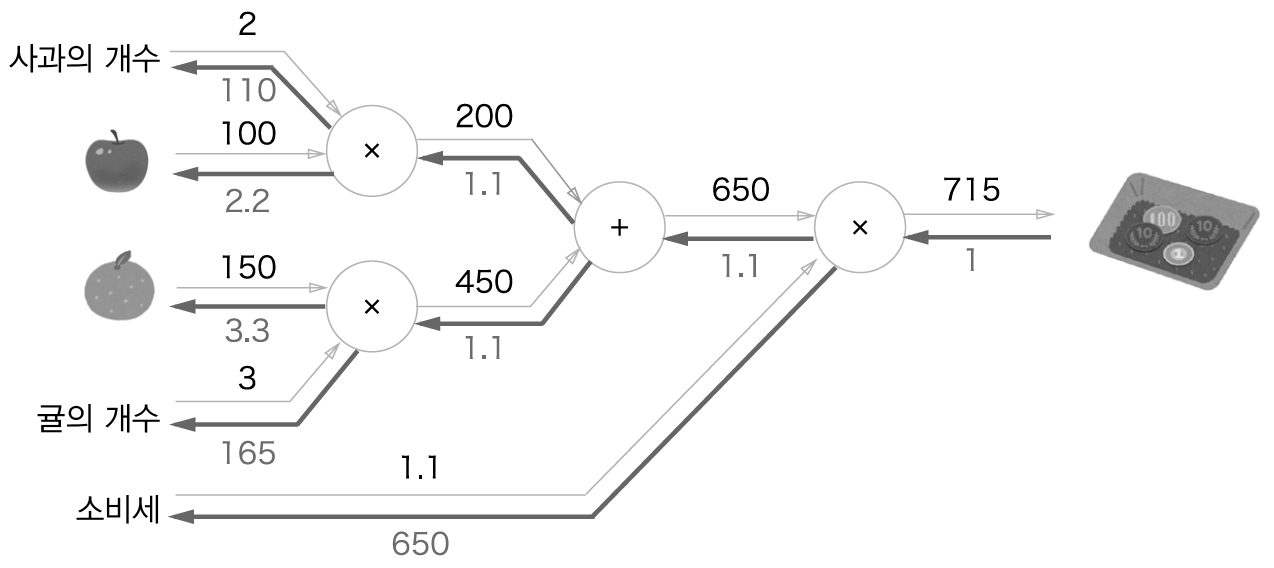

In [10]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-17.png")

[그림5-17]의 계산 그래프를 파이썬으로 구현하면 다음과 같다.

In [12]:
import sys,os
sys.path.append(os.pardir)
from layer_naive import AddLayer, MulLayer

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print(price)  # 715
print(dapple_num, dapple, dorange, dorange_num, dtax)  # 110 2.2 3.3 165 650
    

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


코드가 다소 길어졌으나, 하나하나의 명령은 단순하다. 필요한 계층을 만들어 순전파 메서드인 `forward()`를 적절한 순서로 호출한다. 그런 다음 순전파와 반대 순서로 역전파 메서드인 `backward()`를 호출하면 원하는 미분이 나오게 된다.        

이처럼 계산 그래프에서의 계층(여기에서는 곱셈과 덧셈)은 쉽게 구현할 수 있으며, 이를 사용해 복잡한 미분도 계산할 수 있다. 다음 절에서는 신경망에서 사용하는 계층을 구현해보도록 한다.

## 5.5 활성화 함수 계층 구현하기
드디어 계산 그래프를 신경망에 적용할 때가 왔다. 여기에서는 신경망을 구성하는 층(계층) 각각을 클래스 하나로 구현한다. 우선은 활성화 함수인 ReLU와 Sigmoid 계층을 구현해보도록 한다.

### 5.5.1 ReLU 계층
활성화 함수로 사용되는 ReLU의 수식은 다음과 같다.
\begin{equation*}
    y =
    \begin{cases}
        x & (x>0) \\
        0 & (x \leq 0)
    \end{cases}
\end{equation*} \tag{5.7}

식 (5.7)에서 $x$에 대한 $y$의 미분은 식 (5.8)처럼 구한다.
\begin{equation*}
    \frac{\partial y}{\partial x} =
    \begin{cases}
        1 & (x>0) \\
        0 & (x \leq 0)
    \end{cases}
\end{equation*} \tag{5.8}

식 (5.8)에서와 같이 순전파 때의 입력인 $x$가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘려보낸다. 반면, 순전파 때 $x$가 0 이하이면 역전파 때는 하류로 신호를 흘려보내지 않는다(0을 보낸다). 계산 그래프로는 [그림5-18]처럼 그릴 수 있다.       

#### [그림5-18] ReLU 계층의 계산 그래프

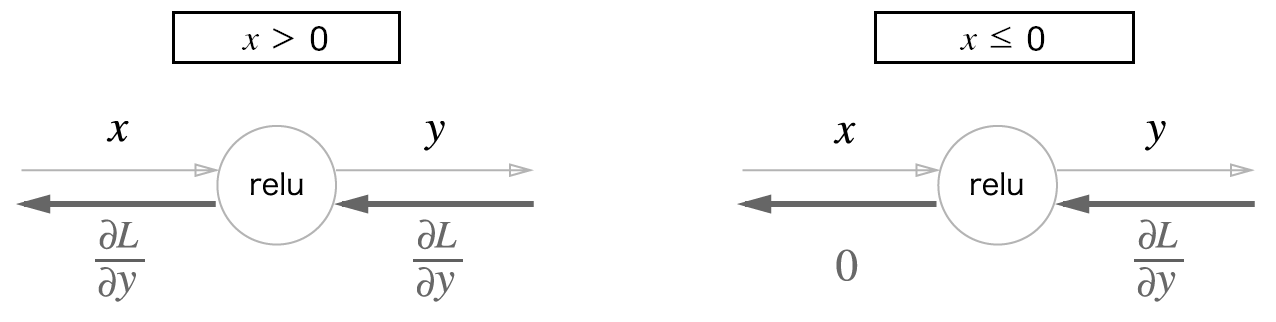

In [14]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-18.png")

이제 이 ReLU 계층을 구현해보자. 신경망 계층의 `forward()`와 `backward()`함수는 넘파이 배열을 인수로 받는다고 가정하자. ReLU 계층을 구현한 코드는 common/layers.py에 있다.

In [18]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0 # 0보다 작은 원소는 0으로 처리, 0보다 큰 원소는 그대로 출력

        return out

    def backward(self, dout):
        dout[self.mask] = 0 # 0보다 작은 원소는 0으로 처리
        dx = dout

        return dx

`Relu`클래스는 `mask`라는 인스턴스 변수를 가진다. `mask`는 `True/False`로 구성된 넘파이 배열로, 순전파의 입력인 `x`의 원소 값이 0 이하인 인덱스는 `True`, 그 외(0보다 큰 원소)는 `False`로 유지한다. 예컨대 `mask`변수는 다음 예와 같이 `True/False`로 구성된 넘파이 배열을 유지한다.

In [20]:
import numpy as np
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )
print(x)
mask = (x <= 0)
print(mask)
out = x.copy()
out[mask] = 0
print(out)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]
[[1. 0.]
 [0. 3.]]


[그림5-18]과 같이 순전파 때의 입력 값이 0이하면 역전파 때의 값은 0이 되어야 한다. 그래서 역전파 때는 순전파 때 만들어둔 `mask`를 써서 `mask`의 원소가 `True`인 곳에는 상류에서 전파된 `dout`을 0으로 설정한다.

$\textbf{NOTE}$     
> ReLU 계층은 전기 회로의 '스위치'에 비유할 수 있다. 순전파 때 전류가 흐르고 있으면 스위치를 ON으로 하고, 흐르지 않으면 OFF로 한다. 역전파 때는 스위치가 ON이라면 전류가 그대로 흐르고, OFF면 더 이상 흐르지 않는다.

### 5.5.2 Sigmoid 계층

다음은 시그모이드 함수 차례이다. 시그모이드 함수는 다음 식을 의미하는 함수이다.

\begin{equation*}
    y = \cfrac{1}{1 + \exp(-x)}
\end{equation*} \tag{5.9}

식 (5.9)를 계산 그래프로 그리면 [그림5-19]처럼 된다.

#### [그림5-19] Sigmoid 계층의 계산 그래프(순전파)

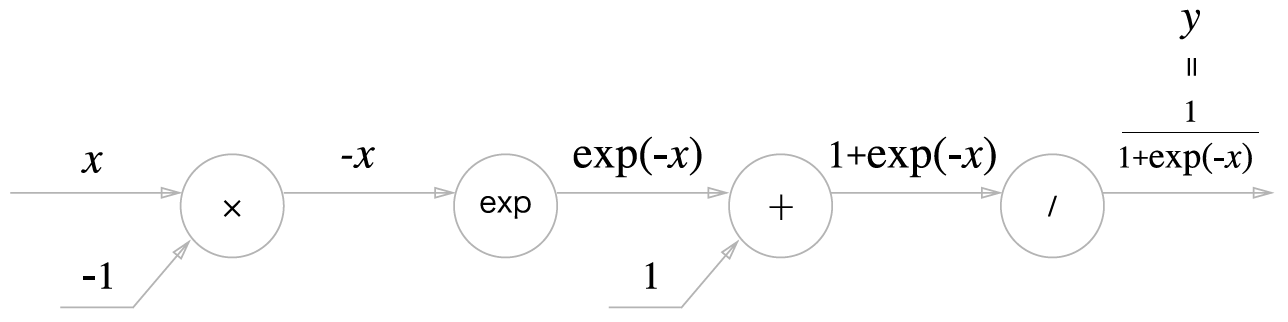

In [21]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-19.png")

[그림5-19]에는 '$\times$'와 '$+$'노드 말고도 'exp'와 '/'노드가 새롭게 등장한다. 'exp'노드는 $y= \exp(x)$계싼을 수행하고 '/'노드는 $\small y = \tfrac{1}{x}$계산을 수행한다.     

[그림5-19]와 같이 식 (5.9)의 계산은 국소적 계산의 전파로 이뤄진다. 이제 [그림5-19]의 역전파를 알아볼 차례이다. 여기에서는 (그동아느이 정리도 겸해) 역전파의 흐름을 오른쪽에서 왼쪽으로 한 단계씩 짚어보고자 한다.

$\textbf{1단계}$        
'/'노드, 즉 $\small y = \tfrac{1}{x}$을 미분하면 다음 식이 된다.

\begin{equation*}
    \frac{\partial y}{\partial x} = - \frac{1}{x^{2}} = - y^{2}
\end{equation*} \tag{5.10}

식 (5.10)에 따르면 역전파 때는 상류에서 흘러온 값에 $\small -y^{2}$(순전파의 출력을 제곱한 후 마이너스를 붙인 값)을 곱해서 하류로 전달한다. 계산 그래프에서는 다음과 같이 표현할 수 있다.

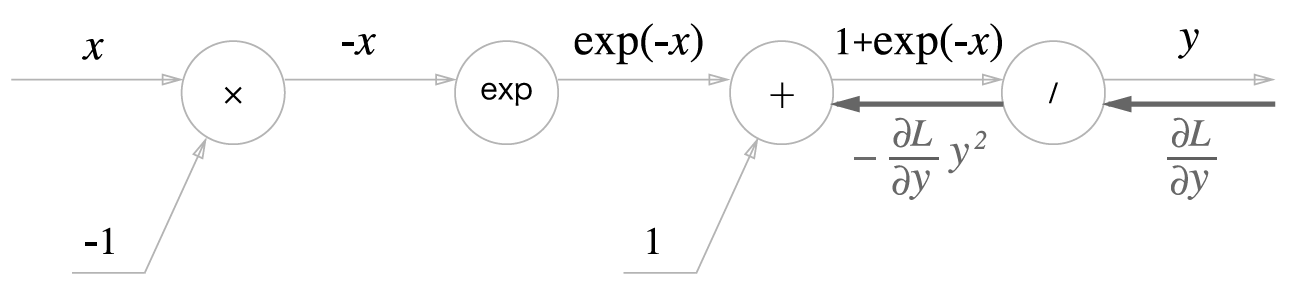

In [23]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-19(1).png")

$\textbf{2단계}$        
'+'노드는 상류의 값을 여과 없이 하류로 내보내는게 전부다. 계산 그래프에서는 다음과 같다.

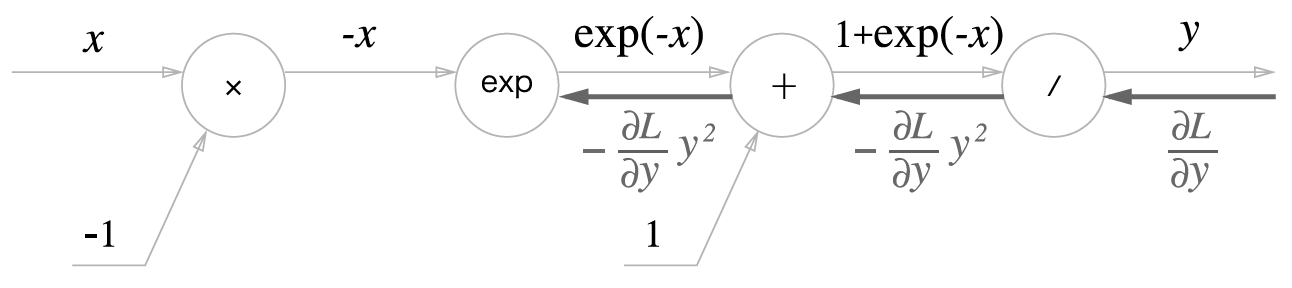

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-19(2).png")

$\textbf{3단계}$        
'exp'노드는 $y=\exp(x)$연산을 수행하며, 그 미분은 다음과 같다.
\begin{equation*}
    \frac{\partial y}{\partial x} = \exp(x)
\end{equation*} \tag{5.11}

계산 그래프에서는 상류의 값에 순전파의 출력 (이 예에서는 $\exp(-x)$)을 곱해 하류로 전파한다.

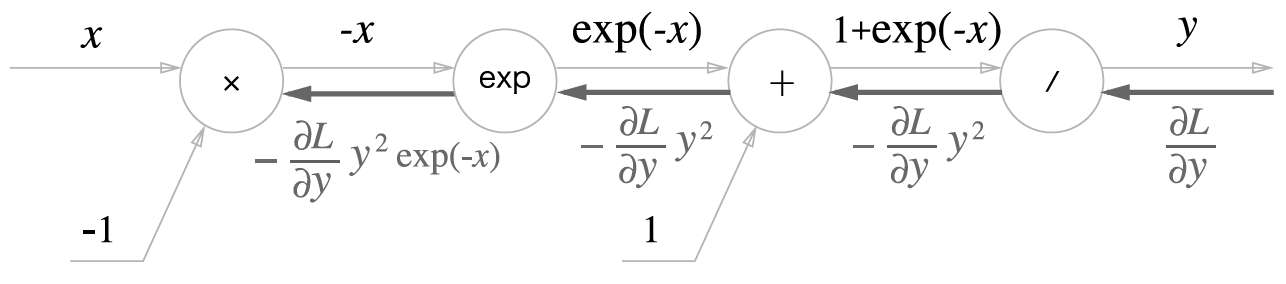

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-19(3).png")

$\textbf{4단계}$        
'$\times$'노드는 순전파 때의 값을 '서로 바꿔' 곱한다. 이 예에서는 -1을 곱하면 되겠다.

#### [그림5-20] Sigmoid 계층의 계산 그래프

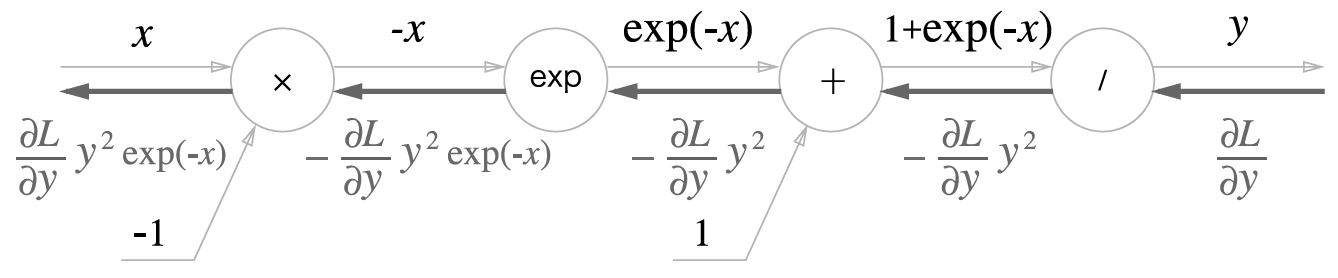

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-20.png")

이상으로 [그림5-20]과 같이 Sigmoid 계층의 역전파를 계산 그래프로 완성하였다. [그림5-20]에서 보듯이 역전파의 최종 출력인 $\small \tfrac{\partial L}{\partial y}y^{2}\exp(-x)$값이 하류 노드로 전파된다. 여기에서 $\small \tfrac{\partial L}{\partial y}y^{2}\exp(-x)$를 순전파의 입력 $x$와 출력 $y$만으로 계산할 수 있다는 것을 눈치챘는가? 그래서 [그림5-20]의 계산 그래프의 중간 과정을 모두 묶어 [그림5-21]처럼 단순한 'sigmoid'노드 하나로 대체할 수 있는 것이다.

#### [그림5-21] Sigmoid 계층의 계산 그래프(간소화 버전)

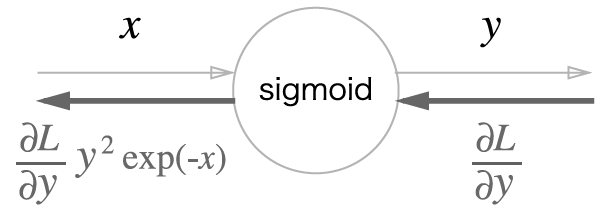

In [5]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-21.png")

[그림5-20]의 계산 그래프와 [그림5-21]의 간소화 버전의 결과는 똑같다. 그러나 간소화 버전은 역전파 과정의 중간 계산들을 생략할 수 있어 더 효율적인 계산이라 말할 수 있다. 또, 노드를 그룹화하여 Sigmoid 계층의 세세한 내용을 노출하지 않고 입력과 출력에만 집중할 수 있다는 것도 중요한 포인트이다.       

또한, $\small \tfrac{\partial L}{\partial y}y^{2}\exp(-x)$는 다음처럼 정리해서 쓸 수 있다.
\begin{align*}
    \frac{\partial L}{\partial y}y^{2}\exp(-x)
    & = \frac{\partial L}{\partial y} \left( \cfrac{1}{1+\exp(-x)} \right)^{2} \exp(-x) \\
    & = \frac{\partial L}{\partial y} \cfrac{1}{1+\exp(-x)} \cfrac{\exp(-x)}{1+\exp(-x)} \\
    & = \frac{\partial L}{\partial y} y (1-y)
\end{align*} \tag{5.12}

이처럼 Sigmoid 계층의 역전파는 순전파의 출력$(y)$만으로 계산할 수 있다.

#### [그림5-22] Sigmoid 계층의 계산 그래프 : 순전파의 출력 $y$만으로 역전파를 계산할 수 있다.

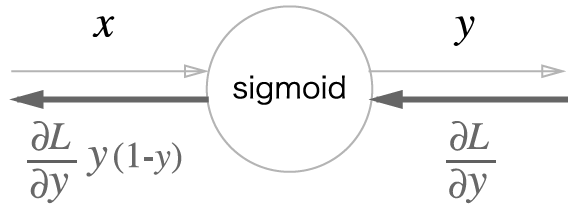

In [6]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-22.png")

그럼 Sigmoid 계층을 파이썬으로는 어떻게 구현할까? [그림5-22]를 참고해 다음과 같이 구현가능하다(소스 코드는 common/layers,py에 있다).

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

이 구현에서는 순전파의 출력을 인스턴스 변수 `out`에 보관했다가, 역전파 계산 때 그 값을 사용한다.

## 5.6 Affine/Softmax 계층 구현하기

### 5.6.1 Affine 계층
신경망의 순전파에서는 가중치 신호의 총합을 계산하기 때문에 행렬의 곱 (넘파이에서는 `np.dot()`)을 사용했다("3.3 다차원 배열의 계산" 참고). 예를 들어 파이썬으로 다음과 같이 구현했던 것을 기억하는가?

In [2]:
import numpy as np

X = np.random.rand(2) # 입력
W = np.random.rand(2,3) # 가중치
B = np.random.rand(3) # 편향

print(X.shape) # (2,)
print(W.shape) # (2, 3)
print(B.shape) # (3,)

Y = np.dot(X, W) + B
print(Y)

(2,)
(2, 3)
(3,)
[0.23118564 0.36486945 1.0385897 ]


여기에서 `X,W,B`는 각각 형상이 $(2,),(2,3),(3,)$인 다차원 배열이다. 그러면 뉴런의 가중치 합은 `Y = np.dot(X,W) + B`처럼 계산하게 된다. 그리고 이 `Y`를 활성화 함수로 변환해 다음 층으로 전파하는 것이 신경망 순전파의 흐름이었다. 복습을 조금 더 해보면, 행렬의 곱 계산은 대응하는 차원의 원소 수를 일치시키는 게 핵심이다. 예를 들어 `X`와 `W`의 곱은 [그림5-23]처럼 대응하는 차원의 원소 수를 일치시켜야 한다. 지금 와서 밝히기엔 좀 새삼스럽지만, 이 책에서 행렬의 형상을 $(2,3)$처럼 괄호로 표기하는 이유는 넘파이의 `shape`함수의 출력과 형태를 통일하기 위해서이다.       

#### [그림5-23] 행렬의 곱에서는 대응하는 차원의 원소 수를 일치시킨다.

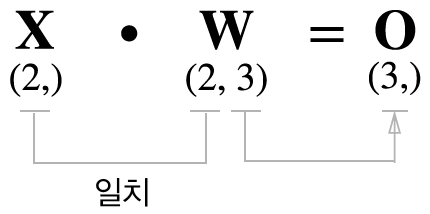

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-23.png")

$\textbf{NOTE}$     
> 신경망의 순전파 때 수행하는 행렬의 곱은 기하학에서는 $\small \textbf{어파인 변환}^{\text{affine transformation}}$이라고 한다. 그래서 이 책에서는 어파인 변환을 수행하는 처리를 'Affine 계층'이라는 이름으로 구현한다.

그럼 앞에서 수행한 계산(행렬의 곱과 편향의 합)을 계산 그래프로 그려보자. 곱을 계산하는 노드를 `dot`라 하면 `np.dot(X,W) + B`계산은 [그림5-24]처럼 그려진다. 또한, 각 변수의 이름 위에 그 변수의 형상도 표기한다. 예를 들어 [그림5-24]에서는 $\mathbf{X}$의 형상은 $(2,),$ $\mathbf{X} \cdot \mathbf{W}$ 의 형상은 $(3,)$임을 표기했다.      

#### [그림5-24] Affine 계층의 계산 그래프 : 변수가 행렬임에 주의. 각 변수의 형상을 변수명 위에 표기했다.

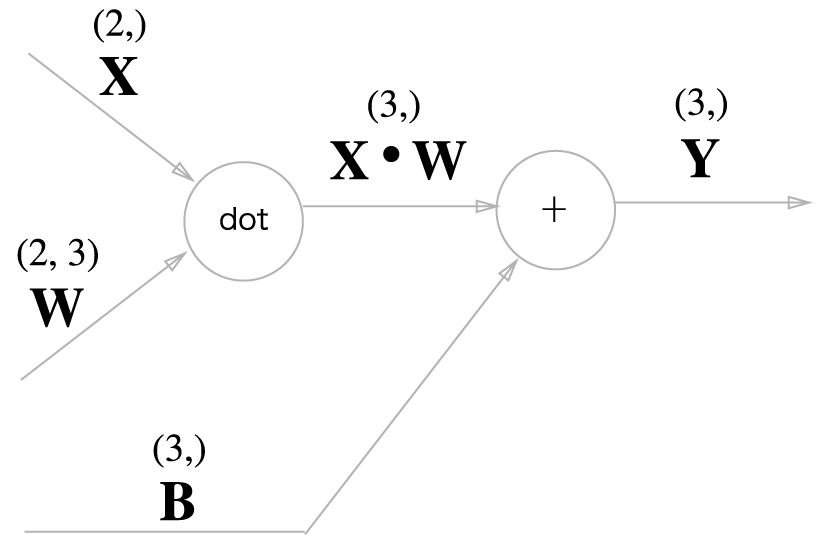

In [5]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-24.png") 

[그림5-24]는 비교적 단순한 계산 그래프이다. 단, $\mathbf{X},\mathbf{W},\mathbf{B}$가 행렬(다차원 배열)이라는 점에 주의하자. 지금까지의 계산 그래프는 노드 사이에 '스칼라값'이 흘렀는데 반해, 이 예에서는 '행렬'이 흐르고 있는 것이다.       

이제 [그림5-24]의 역전파에 대해 생각해보자. 행렬을 사용한 역전파도 행렬의 원소마다 전개해보면 스칼라값을 사용한 지금까지의 계산 그래프와 같은 순서로 생각할 수 있다. 실제로 전개해보면 다음 식이 도출된다 (식 (5.13))

\begin{equation*}
    \frac{\partial L}{\partial \mathbf{X}} = \frac{\partial L}{\partial \mathbf{Y}} \cdot \mathbf{W}^{\top}
\end{equation*}

\begin{equation*}
    \frac{\partial L}{\partial \mathbf{W}} =  \mathbf{X}^{\top} \cdot \frac{\partial L}{\partial \mathbf{Y}} 
\end{equation*} \tag{5.13}

$\textbf{SELF NOTE}$        
> 식 (5.13)은 다음과 같은 과정으로 도출될 수 있다.

먼저 다음과 같은 $\mathbf{X}, \mathbf{W}$를 가정하자.
\begin{equation*}
    \mathbf{X} = [x_1 ~~ x_2 ~~ \cdots~~ x_p]
\end{equation*}

\begin{equation*}
    \mathbf{W} =
    \begin{bmatrix*}
        w_{11} & w_{12} & \cdots & w_{1l} \\
        w_{21} & w_{22} & \cdots & w_{2l} \\
        \vdots & \vdots &  & \vdots \\
        w_{p1} & w_{p2} & \cdots & w_{pl}
    \end{bmatrix*}
\end{equation*}

그러면 $\mathbf{X} \cdot \mathbf{W}$는 다음과 같음을 알 수 있다.
\begin{equation*}
    \mathbf{X}\mathbf{W} = \left[ \displaystyle\sum_{i=1}^{p}x_{i}w_{i1} ~~ \displaystyle\sum_{i=1}^{p} x_{i}w_{i2}~~ \cdots~~ \displaystyle\sum_{i=1}^{p} x_{i}w_{il} \right]
\end{equation*}

그런데 $\frac{\partial (\mathbf{X} \mathbf{W})}{\partial x_{i}} = [w_{i1} ~~ w_{i2} ~~ \cdots ~~ w_{il}],~~i=1,\ldots,p$이므로

\begin{align*}
    \frac{\partial \mathbf{(XW)}}{\partial \mathbf{X}}
    &  = \left[ \left( \frac{\partial \mathbf{(XW)}}{\partial x_{1}} \right)^{\top} ~~ \left( \frac{\partial \mathbf{(XW)}}{\partial x_{2}} \right)^{\top} ~~ \cdots ~~ \left( \frac{\partial \mathbf{(XW)}}{\partial x_{p}} \right)^{\top} \right] \\
    & = 
    \begin{bmatrix}
        w_{11} & w_{21} & \cdots & w_{p1} \\
        w_{12} & w_{22} & \cdots & w_{p2} \\
        \vdots & \vdots &  & \vdots \\
        w_{1l} & w_{2l} & \cdots & w_{pl} \\
    \end{bmatrix}
    = \mathbf{W}^{\top}
\end{align*}

그러므로 다음이 성립하게 된다.

\begin{equation*}
    \frac{\partial L}{\partial \mathbf{X}} = \frac{\partial L}{\partial \mathbf{Y}} \cdot \frac{\partial \mathbf{Y}}{\partial \mathbf{X}} = \frac{\partial L}{\partial \mathbf{Y}} \cdot \frac{\partial (\mathbf{XW + B})}{\partial \mathbf{X}} = \frac{\partial L}{\partial \mathbf{Y}} \cdot \frac{\partial \mathbf{(XW)}}{\partial \mathbf{X}} = \frac{\partial L}{\partial \mathbf{Y}} \cdot \mathbf{W}^{\top}
\end{equation*}

$\frac{\partial L}{\partial \mathbf{W}} =  \mathbf{X}^{\top} \cdot \frac{\partial L}{\partial \mathbf{Y}} $ 도 유사한 방식으로 도출할 수 있다.

식 (5.13)에서 $\mathbf{W}^{\top}$의 $\top$은 전치행렬을 뜻한다. 전치행렬은 $\mathbf{W}$의 $(i,j)$ 위치의 원소를 $(j,i)$위치로 바꾼 것을 말한다. 수식으로는 다음과 같이 쓸 수 있다.

\begin{equation*}
    \mathbf{W} =
    \begin{bmatrix}
        w_{11} & w_{12} & w_{13} \\
        w_{21} & w_{22} & w_{23}
    \end{bmatrix}
\end{equation*}

\begin{equation*}
    \mathbf{W}^{\top} =
    \begin{bmatrix}
        w_{11} & w_{21} \\
        w_{12} & w_{22} \\
        w_{13} & w_{23}
    \end{bmatrix}
\end{equation*} \tag{5.14}

식 (5.14)와 같이 $\mathbf{W}$의 형상이 $(2,3)$이었다면 전치행렬의 $\mathbf{W}^{\top}$의 형상은 $(3,2)$가 된다.      

그럼 식 (5.13)을 바탕으로 계산 그래프의 역전파를 구해보자. 결과는 [그림5-25]처럼 된다.      

#### [그림5-25] Affine 계층의 역전파 : 변수가 다차원 배열임에 주의. 역전파에서의 변수 형상은 해당 변수명 아래에 표기하였다.

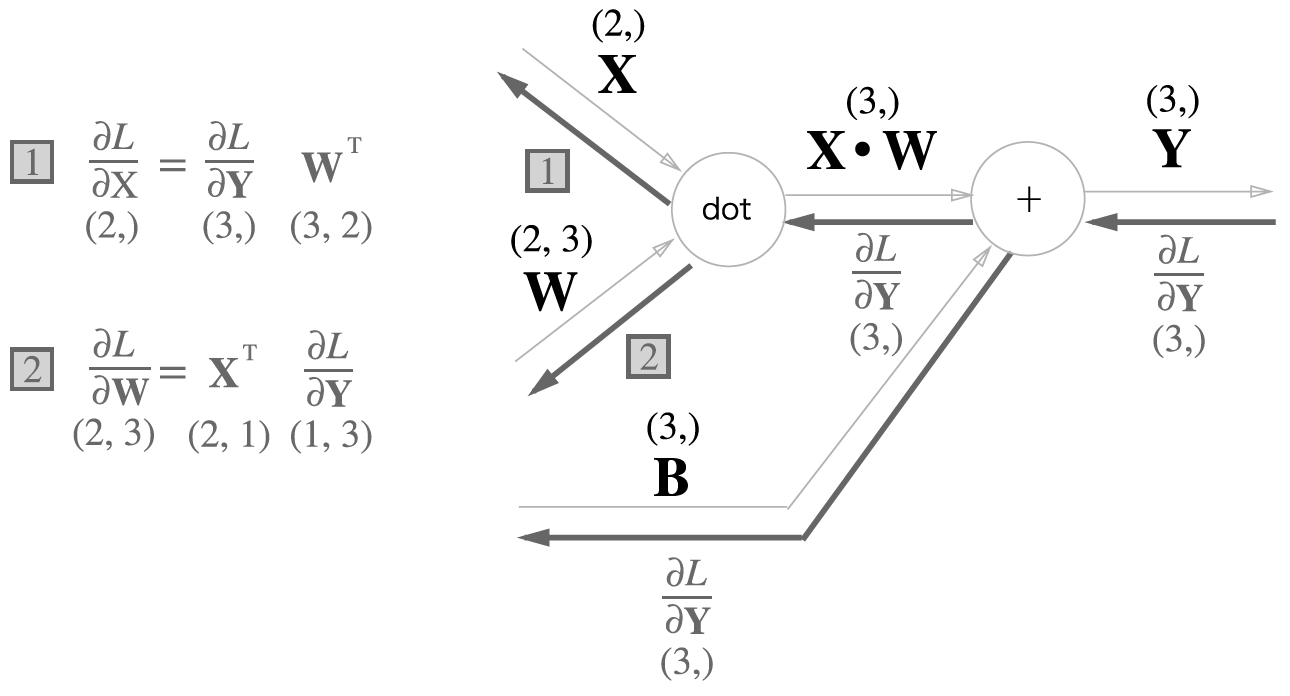

In [6]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-25.png")

[그림5-25]의 계산 그래프에서는 각 변수의 형상에 주의해서 살펴보도록 하자. 특히 $\mathbf{X}$와 $\frac{\partial L}{\partial \mathbf{X}}$는 같은 형상이고, $\mathbf{W}$와 $\frac{\partial L}{\partial \mathbf{W}}$도 같은 형상이라는 것을 기억하자. $\mathbf{X}$와 $\frac{\partial L}{\partial \mathbf{X}}$의 형상이 같다는 것은 다음 식을 보면 명확해진다.        

\begin{equation*}
    \mathbf{X} = (x_0,~ x_1,~ \ldots,~ x_n)
\end{equation*}

\begin{equation*}
    \frac{\partial L}{\partial \mathbf{X}} = \left(\frac{\partial L}{\partial x_0},~ \frac{\partial L}{\partial x_1},~ \ldots,~ \frac{\partial L}{\partial x_n} \right)
\end{equation*} \tag{5.15}

왜 행렬의 형상에 주의해야 할까? 행렬의 곱에서는 대응하는 차원의 원소 수를 일치시켜야 하는데, 이를 위해서는 식 (5.13)을 동원해야 할 수도 있기 때문이다. 예를 들어 $\frac{\partial L}{\partial \mathbf{Y}}$의 형상이 $(3,)$이고 $\mathbf{W}$의 형상이 $(2,3)$일 때, $\frac{\partial L}{\partial \mathbf{X}}$의 형상이 $(2,)$가 되는 $\frac{\partial L}{\partial \mathbf{Y}}$와  $\mathbf{W}$의 곱을 생각해보자([그림5-26]). 그러면 자연스럽게 식 (5.13)이 유도될 수 있을 것이다.

#### [그림5-26] 행렬 곱(`dot` 노드)의 역전파는 행렬의 대응하는 차원의 원소 수가 일치하도록 곱을 조립하여 구할 수 있다.

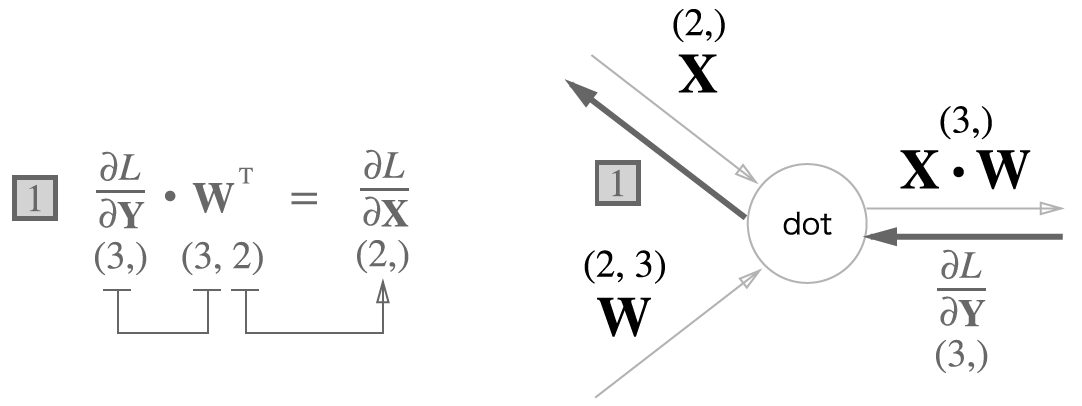

In [7]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-26.png")

### 5.6.2 배치용 Affine 계층

지금까지 설명한 Affine 계층은 입력 데이터로 $\mathbf{X}$ 하나만을 고려한 것이었다. 이번 절에서는 데이터 $N$개를 묶어 순전파하는 경우, 즉 배치용 Affine 계층을 생각해보도록 한다(묶은 데이터를 '배치'라고 부른다).       

그럼 당장 배치용 Affine 계층을 계산 그래프로 그려보자(그림5-27).

#### [그림5-27] 배치용 Affine 계층의 계산 그래프

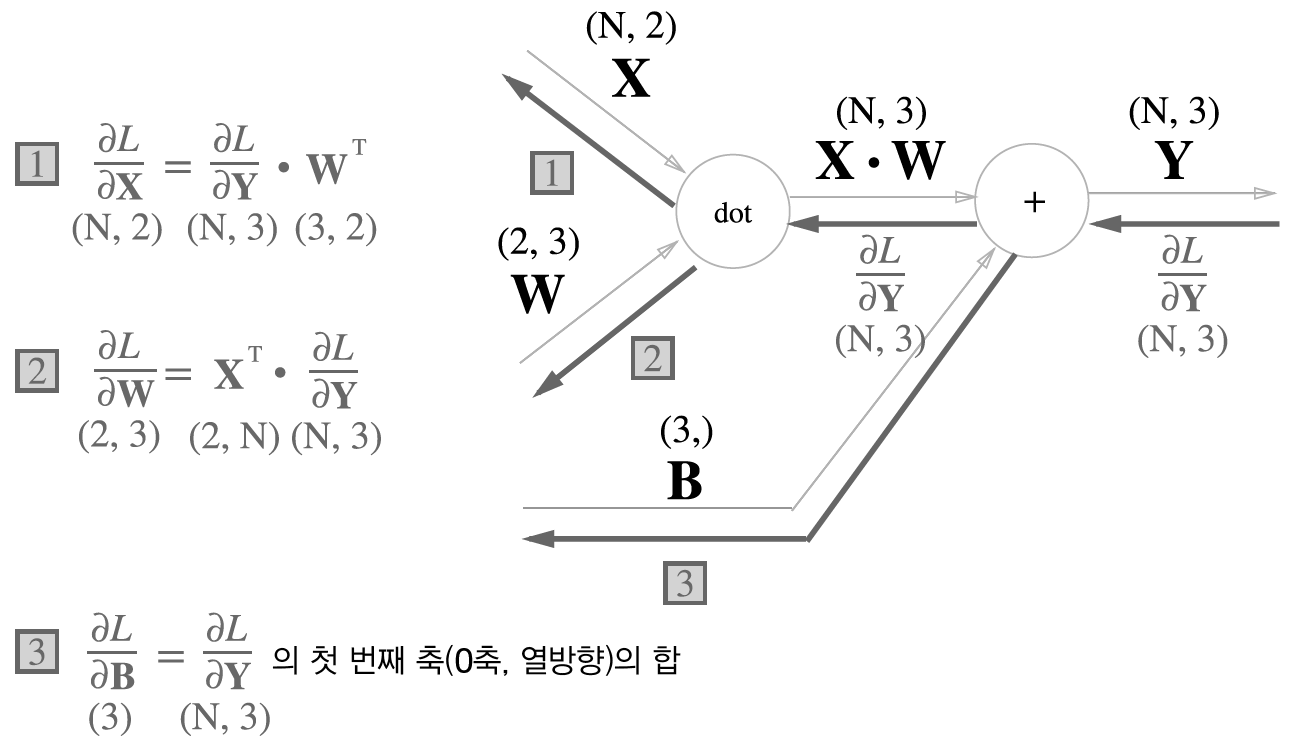

In [8]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-27.png")

기존과 다른 부분은 입력인 $\mathbf{X}$의 형상이 $(N,2)$가 된 것 뿐이다. 그 뒤로는 지금까지와 같이 계산 그래프의 순서를 따라 순순히 행렬 계산을 하게 된다. 또, 역전파 때는 행렬의 형상에 주의하면 $\frac{\partial L}{\partial \mathbf{X}}$와 $\frac{\partial L}{\partial \mathbf{W}}$는 이전과 같이 도출가능하다.        

편향을 더할 때도 주의해야 한다. 순전파 때의 편향 덧셈은 $\mathbf{X} \cdot \mathbf{W}$에 대한 편향이 각 데이터에 더해진다. 예를 들어 $N=2$(데이터가 2개)로 한 경우, 편향은 그 두 데이터 각각에(각각의 계산 결과에) 더해진다. 구체적인 예를 살펴보자.

In [9]:
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

print(X_dot_W)
print(X_dot_W + B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


순전파의 편향 덧셈은 각각의 데이터(1번째 데이터, 2번째 데이터, ...)에 더해진다. 그래서 역전파 때는 각 데이터의 역전파 값이 편향의 원소에 모여야 한다. 코드로는 다음과 같다.

In [11]:
dY = np.array([[1, 2, 3], [4, 5, 6]])
print(dY)
print(dY.shape) # (2, 3)

dB = np.sum(dY, axis=0)
print(dB)

[[1 2 3]
 [4 5 6]]
(2, 3)
[5 7 9]


이 예에서는 데이터가 2개$(N=2)$라고 가정한다. 편향의 역전파는 그 두 데이터에 대한 미분을 데이터마다 더해서 구한다. 그래서 `np.sum()`에서 0번째 축(데이터를 단위로 한 축)에 대해서 (axis=0)의 총합을 구하는 것이다.      

이상의 Affine 구현은 다음과 같다. 참고로, common/layer.py 파일의 Affine 구현은 입력 데이터가 텐서(4차원 데이터)인 경우도 고려한 것이라 다음 구현과는 약간 차이가 있다.

In [13]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

### 5.6.3 Softmax-with-Loss 계층
마지막으로 출력층에서 사용하는 소프트맥스 함수에 관해 설명하고자 한다. 앞에서 말했듯이 소프트맥스 함수는 입력 값을 정규화하여 출력한다. 예를 들어 손글씨 숫자 인식에서의 Softmax 계층의 출력은 [그림5-28]처럼 된다.

#### [그림5-28]
입력 이미지가 Affine 계층과 ReLU 계층을 통과하며 변환되고, 마지막 Softmax 계층에 의해서 10개의 입력이 정규화된다. 이 그림에서는 숫자 '0'의 점수는 5.3이며, 이것이 Softmax 계층에 의해서 0.008(0.8%)로 변환된다. 또, '2'의 점수는 10.1에서 0.991(99.1%)로 변환된다.

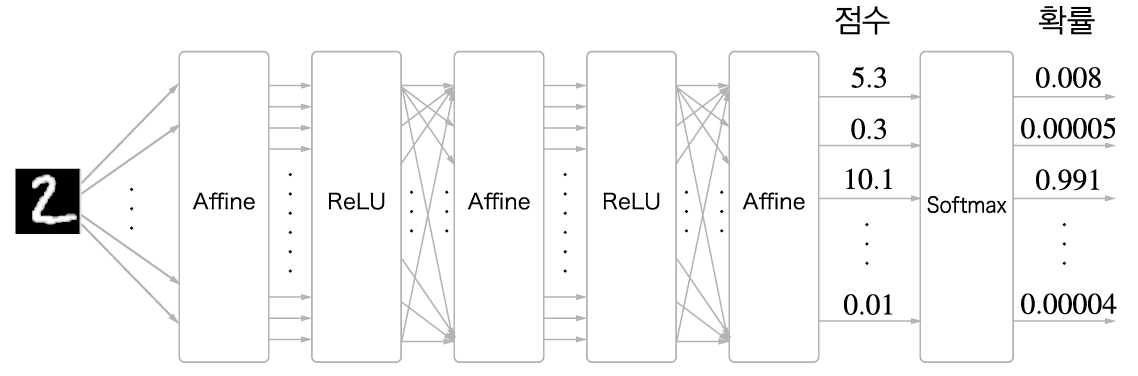

In [12]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-28.png")

[그림5-28]과 같이 Softmax 계층은 입력 값을 정규화(출력의 합이 1이 되도록 변형)하여 출력한다. 또한, 손글씨 숫자는 가짓수가 10개(10클래스 분류)이므로 Softmax 계층의 입력은 10개가 된다.

$\textbf{NOTE}$     
> 신경망에서 수행하는 작업은 $\small \textbf{학습}$과 $\small \textbf{추론}$ 두 가지이다. 추론할 때는 일반적으로 Softmax 계층을 사용하지 않는다. 예컨대 [그림5-28]의 신경망은 추론할 때는 마지막 Affine 계층의 출력을 인식 결과로 이용한다. 또한, 신경망에서 정규화하지 않는 출력 결과([그림5-28]에서는 Softmax 앞의 Affine 계층의 출력)를 $\small \textbf{점수}^{\text{score}}$라 한다. 즉, 신경망 추론에서 답을 한만 내는 경우에는 가장 높은 점수만 알면 되니 Softmax 계층은 필요 없다는 것이다. 반면, 신경망을 학습할 때는 Softmax 계층이 필요하다.      

이제 소프트맥스 계층을 구현할 텐데, 손실 함수인 교차 엔트로피 오차도 포함하여 'Softmax-with-Loss 계층'이라는 이름으로 구현하게 된다. 먼저 Softmax-with-Loss 계층의 계산 그래프를 살펴보자(그림5-29).

#### [그림5-29] Softmax-with-Loss 계층의 계산 그래프

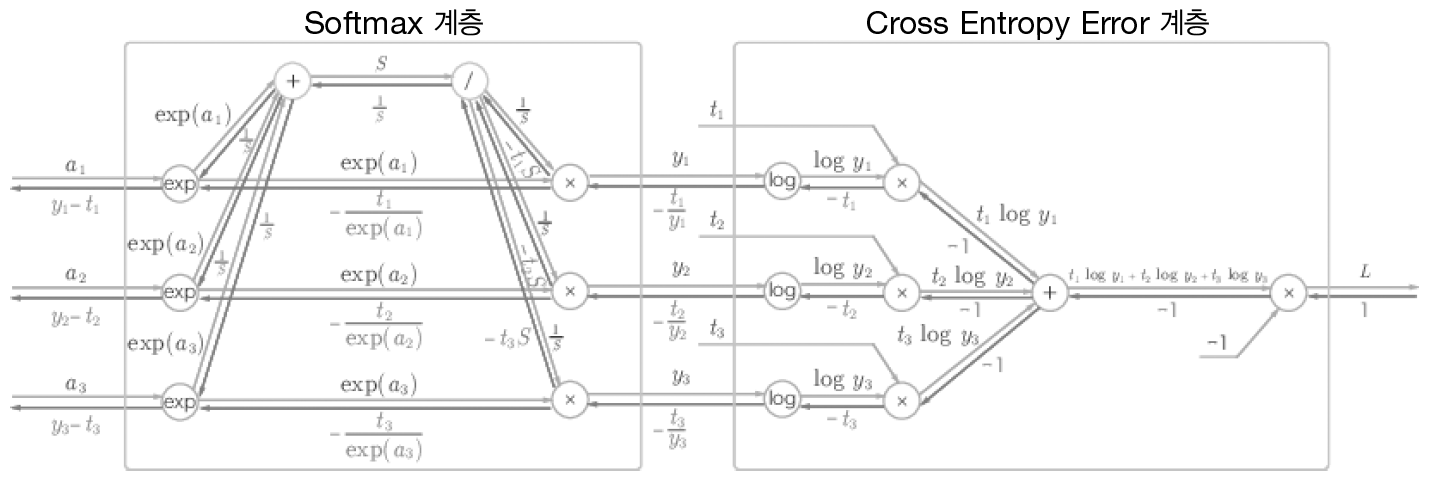

In [14]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-29.png")

보다시피 Softmax-with-Loss 계층은 다소 복잡하다. [그림5-29]의 계산 그래프는 [그림5-30]처럼 간소화할 수 있다.        

#### [그림5-30] '간소화한' Softmax-with-Loss 계층의 계산 그래프

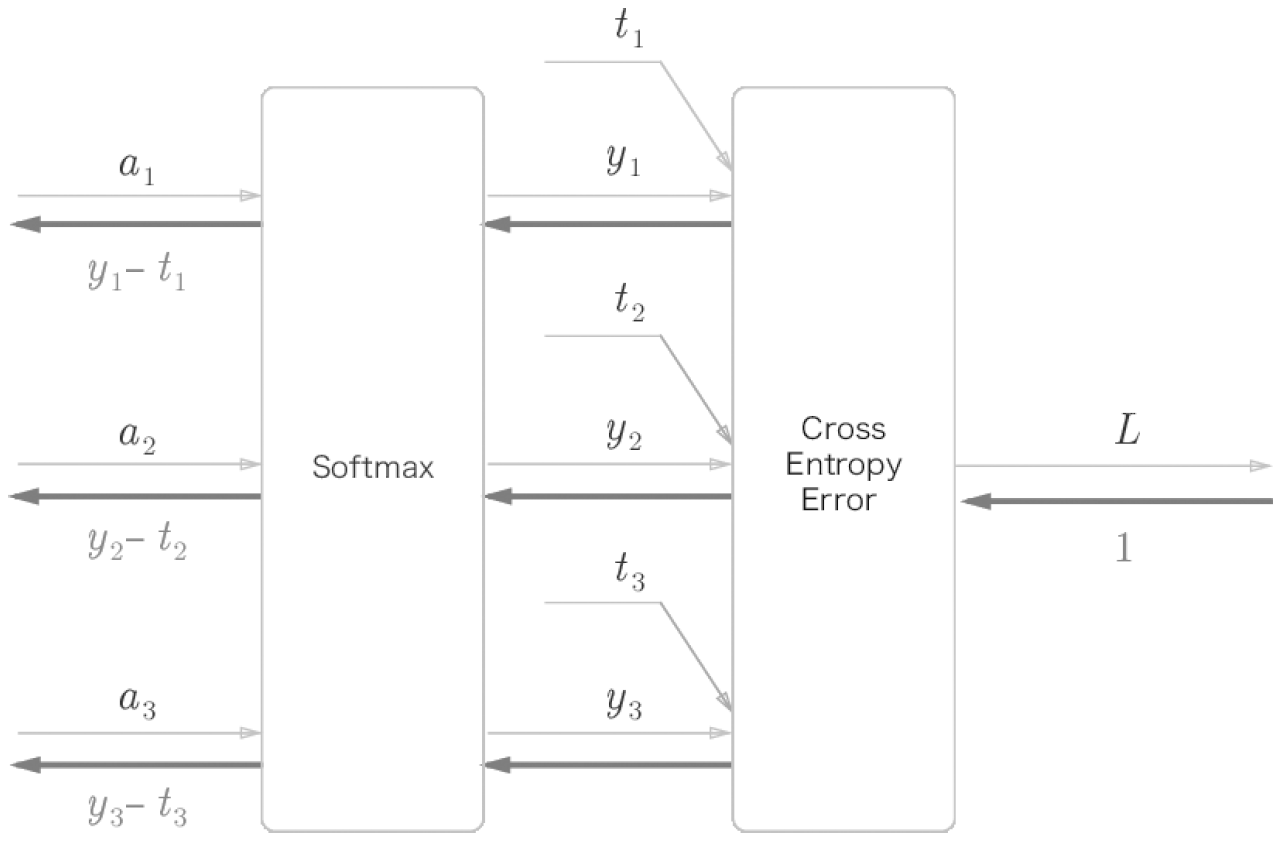

In [15]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter-5\\images\\fig 5-30.png")

[그림5-30]의 계산 그래프에서 소프트맥스 함수는 'Softmax'계층으로, 교차 엔트로피 오차는 'Cross Entropy Error'계층으로 표기하였다. 여기에서는 3클래스트 분류를 가정하고 이전 계층에서 3개의 입력 (점수)을 받는다. 그림과 같이 Softmax 계층은 입력 $(a_1,a_2,a_3)$를 정규화하여 $(y_1, y_2, y_3)$를 출력한다. Cross Entropy Error 계층은 Softmax의 출력 $(y_1,y_2,y_3)$와 정답 레이블 $(t_1,t_2,t_3)$를 받고, 이 데이터들로부터 손실 $L$을 출력한다.

[그림5-30]에서 주목할 것은 역전파의 결과이다. Softmax 계층의 역전파는 $(y_1-t_1,y_2-t_2,y_3-t_3)$라는 '말끔한'결과를 내놓고 있다. $(y_1,y_2,y_3)$는 Softmax 계층의 출력이고 $(t_1,t_2,t_3)$는 정답 레이블이므로, $(y_1-t_1,y_2-t_2,y_3-t_3)$는 Softmax 계층의 출력과 정답 레이블의 차분인 것이다. 신경망의 역전파에서는 이 차이인 오차가 앞 계층에 전해지는 것이다. 이는 신경망 학습의 중요한 성질이다.

그런데 신경망 학습의 목적은 신경망의 출력 (Softmax의 출력)이 정답 레이블과 가까워지도록 가중치 매개변수의 값을 조정하는 것이었다. 그래서 신경망의 출력과 정답 레이블의 오차를 효율적으로 앞 계층에 전달해야 한다. 앞의 $(y_1 - t_1, y_2 - t_2, y_3 -t_3)$라는 결과는 바로 Softmax 계층의 출력과 정답 레이블의 차이로, 신경망의 현재 출력과 정답 레이블의 오차를 있는 그대로 드러내는 것이다.

$\textbf{NOTE}$     
> '소프트맥스 함수'의 손실 함수로 '교차 엔트로피 오차'를 사용하니 역전파가 $(y_1 -t_1, y_2-t_2, y_3-t_3)$로 말끔히 떨어짐을 확인하였다. 사실 이런 말끔함은 우연이 아니라 교차 엔트로피 오차라는 함수가 그렇게 설계되었기 때문이다. 또, 회귀의 출력층에서 사용하는 '항등 함수'의 손실 함수로 '오차제곱합'을 이용하는 이유도 이와 같다. 즉, '항등 함수'의 손실 함수로 '오차제곱합'을 사용하면 역전파의 결과가 $(y_1 -t_1, y_2-t_2, y_3-t_3)$로 말끔히 떨어지게 된다.

$\textbf{SELF NOTE}$        
> Softmax-with-Loss 계층의 역전파가 어떻게 계산되는지 좀 더 심층적으로 살펴보자.        

먼저 분류되는 클래스 개수를 $K$라고 가정해보자. 그러면 손실함수 $L$은 다음과 같음을 알 수 있다.

\begin{equation*}
    L = - \displaystyle\sum_{k=1}^{K} t_{k} \log y_k
\end{equation*}

이때 $y_k$는 Softmax함수에 의해 다음과 같이 정의됨을 알고 있다.

\begin{equation*}
    y_k = \cfrac{\exp({a_k})}{\displaystyle\sum_{k=1}^{K}\exp({a_k})}
\end{equation*}

이제 예측값 $y_k,~k=1,\ldots,K$에 대해 $L$을 미분해보면 다음과 같음을 알 수 있다.

\begin{equation*}
    \frac{\partial L}{\partial y_k} = \frac{\partial}{\partial y_k} \left\{ - \displaystyle\sum_{k=1}^{K} t_{k} \log y_k \right\} = - \frac{\partial}{\partial y_k} (t_k \log y_k) = - \frac{t_k}{y_k}
\end{equation*}

이때 score값 $a_j,~j=1,\ldots,K$에 대한 $y_k$의 미분값을 구해보면 다음과 같다.

\begin{equation*}
    \frac{\partial y_k}{\partial a_j} = \cfrac{\partial}{\partial a_j} \left( \cfrac{\exp({a_k})}{\textstyle\sum_{k=1}^{K}\exp({a_k})} \right) = \left( \cfrac{\exp({a_k})}{\textstyle\sum_{k=1}^{K}\exp({a_k})} \right) \cdot \left( I(k=j) - \cfrac{\exp({a_j})}{\textstyle\sum_{k=1}^{K}\exp({a_k})} \right) = y_k \left( I(k=j) - y_j \right)
\end{equation*}

그러면 $a_j,~j=1,\ldots,K$에 대한 $L$의 미분값은 연쇄 법칙(chain rule)에 의해 다음과 같게 된다.
\begin{align*}
    \frac{\partial L}{\partial a_j}
    & = \displaystyle\sum_{k=1}^{K} \left( \frac{\partial L}{\partial y_k}\right) \left( \frac{\partial y_k}{\partial a_j} \right) \\
    & = - \displaystyle\sum_{k=1}^{K} \frac{t_{k}}{y_k} \{y_k \left( I(k=j) - y_j \right)\} \\ 
    & = - \left\{ t_1(0 - y_j) + t_2(0 - y_j) + \cdots + t_j(1 - y_j) + \cdots + t_K(0 - y_j) \right\} \\
    & = y_j(t_1 + t_2 + \cdots + t_K) - t_j \\
    & = y_j - t_j ~~~~ (\because \textstyle\sum_{k=1}^{K}t_k = 1)
\end{align*}

연쇄 법칙을 사용하지 않는 경우는 다음과 같다.

\begin{align*}
    \frac{\partial L}{\partial a_j}
    & = \frac{\partial }{\partial a_j} \left\{ - \displaystyle\sum_{k=1}^{K} t_{k} \log y_k \right\} \\
    & = - \displaystyle\sum_{k=1}^{K} \frac{t_{k}}{y_k} \frac{\partial y_k}{\partial a_j} \\
    & = - \displaystyle\sum_{k=1}^{K} \frac{t_{k}}{y_k} \{y_k \left( I(k=j) - y_j \right)\} \\ 
    & = - \left\{ t_1(0 - y_j) + t_2(0 - y_j) + \cdots + t_j(1 - y_j) + \cdots + t_K(0 - y_j) \right\} \\
    & = y_j(t_1 + t_2 + \cdots + t_K) - t_j \\
    & = y_j - t_j ~~~~ (\because \textstyle\sum_{k=1}^{K}t_k = 1)
\end{align*}

그러므로 모든 클래스의 스코어값 $a_k,~k=1,\ldots, K$에 대해 $L$의 미분값은 $y_k - t_k$와 같음을 알 수 있다.

이쯤에서 구체적인 예를 하나 보는게 좋을 것 같다. 가령 정답 레이블이 $(0,1,0)$일 때 Softmax 계층이 $(0.3, 0.2, 0.5)$를 출력했다고 가정해보자. 정답 레이블을 보면 정답의 인덱스는 1이다. 그런데 출력에서는 이때의 확률이 겨우 0.2(20%)라서, 이 시점의 신경망은 제대로 인식하지 못하고 있다. 이 경우 Softmax 계층의 역전파는 $(0.3, -0.8, 0.5)$라는 커다란 오차를 전파한다. 결과적으로 Softmax 계층의 앞 계층들은 그 큰 오차로부터 큰 깨달음을 얻게 된다.

이번에 살펴볼 예는 정답 레이블이 똑같이 $(0,1,0)$일 때 Softmax 계층이 $(0.01,0.99,0)$을 출력한 경우이다(이 신경망은 꽤 정확히 인식하고 있는 것 같다). 이 경우 Softmax 계층의 역전파가 보내는 오차는 비교적 작은 $(0.01, -0.01, 0)$이다. 이번에는 앞 계층으로 전달된 오차가 작으므로 학습하는 정도도 작아진다.

$\textbf{SELF NOTE}$        
> 위의 예와 같이, Softmax 계층의 역전파가 커다란 기울기를 전파하는 경우, 신경망의 가중치 매개변수를 조정하게 될 때 그 기울기만큼의 크기로 가중치를 경사하강법을 통해 수정하게 된다. 이것이 신경망 학습의 원리이다. 마찬가지로 Softmax 계층의 역전파가 매우 작은 기울기를 전파하는 경우, 매우 작은 수준의 기울기크기로 가중치를 경사하강법을 통해 수정하게 된다.

그럼 Softmax-with-Loss 계층을 구현한 코드를 살펴보자.

In [1]:
import os, sys
sys.path.append(os.pardir)
from common.functions import softmax, cross_entropy_error

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

이 구현에서는 "3.5.2 소프트맥스 함수 구현 시 주의점"과 "4.2.4 (배치용) 교차 엔트로피 오차 구현하기"에서 구현한 함수인 `softmax()`와 `cross_entropy_error()`를 이용하였다. 그 덕분에 이번 구현은 매우 간단하다. 또, 역전파 때는 전파하는 값의 배치의 수(`batch_size`)로 나눠서 데이터 1개당 오차를 앞 계층으로 전파하는 점에 주의하자.

## 5.7 오차역전파법 구현하기
앞 절에서 구현한 계층을 조합하면 마치 레고 블록을 조립하듯 신경망을 구축할 수 있다.     
이번 절에서는 지금까지 구현한 계층을 조합해서 신경망을 구축해보도록 한다.

### 5.7.1 신경망 학습의 전체 그림
이야기가 조금 길어졌으니, 구체적인 구현에 들어가기 전에 신경망 학습의 전체 그림을 복습해보자. 다음은 신경망 학습의 순서이다.        

$\textbf{전제}$     
> 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.     

$\textbf{1단계 - 미니 배치}$     
> 훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니 배치라 하며, 그 미니 배치의 손실 함수 값을 줄이는 것이 목표이다.     

$\textbf{2단계 - 기울기 산출}$     
> 미니 배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.     

$\textbf{3단계 - 매개변수 갱신}$     
> 가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.     

$\textbf{4단계 - 반복}$     
> 1~3단계를 반복한다.

지금까지 설명한 오차역전파법이 등장하는 단계는 두 번째인 '기울기 산출'이다. 앞 장에서는 이 기울기를 구하기 위해서 수치 미분을 사용하였다. 그런데 수치 미분은 구현하기는 쉽지만 계산이 오래 걸렸다. 오차역전파법을 이용하면 느린 수치 미분과 달리 기울기를 효율적이고 빠르게 구할 수 있다.

### 5.7.2 오차역전파법을 적용한 신경망 구현하기
드디어 본격적인 구현이다. 여기에서는 2층 신경망을 TwoLayerNet 클래스로 구현한다.        
우선은 이 클래스의 인스턴스 변수와 메서드를 정리한 [표5-1]과 [표5-2]를 살펴보자.

##### [표5-1] TwoLayerNet 클래스의 인스턴스 변수

| 변수명 | 설명 |
|--------|------|
| params | 신경망의 매개변수를 보관하는 딕셔너리 변수입니다. <br>- `params['W1']`: 1번째 층의 가중치 <br>- `params['b1']`: 1번째 층의 편향 <br>- `params['W2']`: 2번째 층의 가중치 <br>- `params['b2']`: 2번째 층의 편향 |
| layers | 신경망의 계층을 보관하는 딕셔너리 변수입니다. <br>- `layers['Affine1']`, `layers['Relu1']`, <br> `layers['Affine2']` 와 같이 각 계층을 순서대로 유지|
| lastLayer | 신경망의 마지막 계층 딕셔너리 변수입니다. <br>이 예에서는 SoftmaxWithLoss 계층|


##### [표5-2] TwoLayerNet 클래스의 메서드

| 메서드 | 설명 |
|--------|------|
| `__init__`(self, input_size, <br> hidden_size, output_size, <br>weight_init_std) | 초기화를 수행한다. <br> 인수는 순서대로 입력층의 뉴런 수, 은닉층의 뉴런 수, 출력층의 뉴런 수,<br> 가중치 초기화 시 정규분포의 스케일  |
| `predict(self,x)` | 예측을 수행한다. <br> 인수 `x`는 이미지 데이터 |
| `loss(self,x,t)` | 손실 함수의 값을 계산한다. <br> 인수 `x`는 이미지 데이터, `t`는 정답 레이블|
| `accuracy(self,x,t)` | 정확도를 계산한다. |
| `numerical_gradient(self,x,t)` | 가중치 매개변수의 기울기를 수치 미분 방식으로 계산한다. |
| `gradient(self,x,t)` | 가중치 매개변수의 기울기를 오차역전파법으로 계산한다. |


이 클래스의 구현은 좀 긴 건 사실이지만, 그 내용은 "4.5 학습 알고리즘 구현하기"와 공통되는 부분이 많다. 앞 장과 크게 다른 부분은 계층을 사용한다는 점이다. 계층을 사용함으로써 인식 결과를 얻는 처리 (`predict()`)와 기울기를 구하는 처리(`gradient()`) 계층의 전파만으로 동작이 이루어지는 것이다. 그럼 코드를 한 번 살펴보자.

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads

이 구현에서는 굵은 글씨들을 집중해서 살펴보자. 특히 신경망의 계층을 `OrderedDict`에 보관하는 점이 중요하다. `OrderedDict`는 순서가 있는 딕셔너리이다. '순서가 있는'이란 딕셔너리에 추가한 순서를 기억한다는 것이다. 그래서 순전파 때는 추가한 순서대로 각 계층의 `forward()`메서드를 호출하기만 하면 처리가 완료된다. 마찬가지로 역전파 때는 계층을 반대 순서로 호출하기만 하면 된다. Affine계층과 ReLU계층이 각자의 내부에서 순전파와 역전파를 제대로 처리하고 있으니, 여기에서는 그냥 계층을 올바른 순서대로 연결한 다음 순서대로 (혹은 역순으로)호출해주면 끝이다.       

이처럼 신경망의 모든 구성 요소를 '계층'으로 구현한 덕분에 신경망을 쉽게 구축할 수 있었다. '계층'으로 모듈화해서 구현한 효과는 아주 크다. 예컨대, 5층, 10층, 20층, ...과 같이 깊은 신경망을 만들고 싶다면, 단순히 필요한 만큼 계층을 더 추가하면 되기 때문이다(마치 레고 블록을 조립하듯).       

이어서 다음 절에서는 각 계층 내부에 구현된 순전파와 역전파를 활용해 인식 처리와 학습에 필요한 기울기를 정확하게 구해보도록 하자.

### 5.7.3 오차역전파법으로 구한 기울기 검증하기
지금까지 기울기를 구하는 방법을 두 가지 설명해보았다. 하나는 수치 미분을 써서 구하는 방법, 또 하나는 해석적으로 수식을 풀어 구하는 방법이다. 후자인 해석적 방법은 오차역전파법을 이용하여 매개변수가 많아도 효율적으로 계산할 수 있었다. 그러니 이제부터는 느린 수치 미분 대신 오차역전파법을 사용하기로 하자.      

수치 미분은 느리다. 그리고 오차역전파법을 제대로 구현해두면 수치 미분은 더 이상 필요하지 않다. 그렇다면 수치 미분은 정말 아무런 쓸모가 없을까? 사실은 수치 미분은 오차역전파법을 정확히 구현했는지 확인하기 위해 필요하다.      

수치 미분의 이점은 구현하기 쉽다는 것이다. 그래서 수치 미분의 구현에는 버그가 숨어 있기 어려운 반면, 오차역전파법은 구현하기 복잡해서 종종 실수를 하곤 한다. 그래서 수치 미분의 결과와 오차역전파법의 결과를 비교하여 오차역전파법을 제대로 구현했는지 검증하곤 한다. 이처럼 두 방식으로 구한 기울기가 일치함(엄밀히 말하면 거의 같음)을 확인하는 작업을 $\small \textbf{기울기 확인}^{\text{gradient check}}$이라고 한다. 기울기 확인은 다음과 같이 구현한다.

In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)   

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:3.759739027473689e-10
b1:2.4707947466544136e-09
W2:4.004744211068121e-09
b2:1.3993042232568476e-07


언제나처럼 가장 먼저 MNIST 데이터셋을 읽는다. 그리고 훈련 데이터 일부를 수치 미분으로 구한 기울기와 오차역전파법으로 구한 기울기의 오차를 확인한다. 여기에서는 각 가중치 매개변수의 차이의 절댓값을 구하고, 이를 평균한 값이 오차가 된다. 코드의 실행 결과는 위와 같다.     

이 결과는 수치 미분과 오차역전파법으로 구한 기울기의 차이가 매우 작다고 말해준다. 가령 1번째 층의 기울기 오차는 3.759e-10(0.0000000003759)이다. 이로써 오차역전파법으로 구한 기울기도 올바름이 드러나면서 실수 없이 구현했다는 믿음이 커지는 것이다.

$\textbf{NOTE}$     
> 수치 미분과 오차역전파법의 결과 오차가 0이 되는 일은 드물다. 이는 컴퓨터가 할 수 있는 계산의 정밀도가 유한하기 때문이다(가령 32비트 부동소수점). 이 정밀도의 한계 때문에 오차는 대부분 0이 되지는 않지만, 올바르게 구현했다면 0에 아주 가까운 작은 값이 된다. 만약 그 값이 크면 오차역전파법을 잘못 구현했다고 의심해봐야 할 것이다.

### 5.7.4 오차역전파법을 사용한 학습 구현하기
마지막으로 오차역전파법을 사용한 신경망 학습을 구현해보자. 지금까지와 다른 부분은 기울기를 오차역전파법으로 구한다는 점뿐이다.

In [3]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 60000
train_size = x_train.shape[0] # 60000
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1) # 1에폭당 반복 수

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"{int(i//iter_per_epoch)+1}에폭 | 훈련 정확도 : {train_acc}, 시험 정확도 :  {test_acc} " )

1에폭 | 훈련 정확도 : 0.13526666666666667, 시험 정확도 :  0.1376 


2에폭 | 훈련 정확도 : 0.9055666666666666, 시험 정확도 :  0.9092 
3에폭 | 훈련 정확도 : 0.9252833333333333, 시험 정확도 :  0.9257 
4에폭 | 훈련 정확도 : 0.9391333333333334, 시험 정확도 :  0.9399 
5에폭 | 훈련 정확도 : 0.9469, 시험 정확도 :  0.9454 
6에폭 | 훈련 정확도 : 0.9530166666666666, 시험 정확도 :  0.9521 
7에폭 | 훈련 정확도 : 0.9584833333333334, 시험 정확도 :  0.9556 
8에폭 | 훈련 정확도 : 0.9624166666666667, 시험 정확도 :  0.9582 
9에폭 | 훈련 정확도 : 0.9651166666666666, 시험 정확도 :  0.9608 
10에폭 | 훈련 정확도 : 0.9682833333333334, 시험 정확도 :  0.9626 
11에폭 | 훈련 정확도 : 0.9695666666666667, 시험 정확도 :  0.9648 
12에폭 | 훈련 정확도 : 0.9722, 시험 정확도 :  0.9656 
13에폭 | 훈련 정확도 : 0.9741166666666666, 시험 정확도 :  0.9681 
14에폭 | 훈련 정확도 : 0.97665, 시험 정확도 :  0.9674 
15에폭 | 훈련 정확도 : 0.9774166666666667, 시험 정확도 :  0.9686 
16에폭 | 훈련 정확도 : 0.97915, 시험 정확도 :  0.9698 
17에폭 | 훈련 정확도 : 0.9800333333333333, 시험 정확도 :  0.9713 
18에폭 | 훈련 정확도 : 0.9800166666666666, 시험 정확도 :  0.9702 
19에폭 | 훈련 정확도 : 0.9815, 시험 정확도 :  0.9726 
20에폭 | 훈련 정확도 : 0.9816333333333334, 시험 정확도 :  0.9708 
21에폭 | 훈련 정확도 : 0.9829833333333333, 시험 정

## 5.8 정리
이번 장에서는 계산 과정을 시각적으로 보여주는 방법인 계산 그래프를 배웠다. 계산 그래프를 이용하여 신경망의 동작과 오차역전파법을 설명하고, 그 처리 과정을 계층이라는 단위로 구현하였다. 예를 들어 ReLU 계층, Softmax-with-Loss 계층, Affine 계층, Softmax 계층 등이다. 모든 계층에서 `forward`와 `backward`라는 메서드를 구현한다. 전자는 데이터를 순방향으로 전파하고, 후자는 역방향으로 전파함으로써 가중치 매개변수의 기울기를 효율적으로 구할 수 있다. 이처럼 동작을 계층으로 모듈화한 덕분에, 신경망의 계층을 자유롭게 조합하여 원하는 신경망을 쉽게 만들 수 있다.

#### 이번 장에서 배운 내용
- 계산 그래프를 이용하면 계산 과정을 시각적으로 파악할 수 있다.
- 계산 그래프의 노드는 국소적 계산으로 구성된다. 국소적 계산을 조합해 전체 계산을 구성한다.
- 계산 그래프의 순전파는 통상의 계산을 수행한다. 한편, 계산 그래프의 역전파로는 각 노드의 미분을 구할 수 있다.
- 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다(오차역전파법).
- 수치 미분과 오차역전파법의 결과를 비교하면 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다(기울기 확인).

$\textbf{References}$
- https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1